In [1]:
import polars as pl

In [2]:
train = pl.read_csv("m5-forecasting-accuracy\sales_train_validation.csv")
calendar = pl.read_csv("m5-forecasting-accuracy\calendar.csv")

In [3]:
train = (
    train
    .melt(id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"])
    .join(
        calendar.select(
            pl.col("d"),
            pl.col("date")
        ),
        left_on="variable",
        right_on="d",
    )
    .with_columns(
        pl.col("date").str.strptime(pl.Date)
    ) 
    .with_columns(
        (
            (pl.col("date") + pl.duration(days=1))
            .dt.truncate("1w")
            - pl.duration(days=1)
        ).alias("week_end")
    )
)


train = train.with_columns(
    (pl.col("dept_id") + "_" + pl.col("store_id")).alias("unique_id")
)

# Step 2: Group by week_end and unique_id, and sum the sales
weekly_train = (
    train
    .group_by(["unique_id", "week_end"])
    .agg(
        pl.col("value").sum().alias("y")
    )
    .sort(["unique_id", "week_end"])
    .rename({"week_end": "ds"})
)

C:\Users\janli\AppData\Local\Temp\ipykernel_8316\575336382.py:3: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  .melt(id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"])


In [4]:
weekly_train

shape: (19_250, 3)
┌──────────────────┬────────────┬──────┐
│ unique_id        ┆ ds         ┆ y    │
│ ---              ┆ ---        ┆ ---  │
│ str              ┆ date       ┆ i64  │
╞══════════════════╪════════════╪══════╡
│ FOODS_1_CA_1     ┆ 2011-01-23 ┆ 297  │
│ FOODS_1_CA_1     ┆ 2011-01-30 ┆ 1533 │
│ FOODS_1_CA_1     ┆ 2011-02-06 ┆ 1772 │
│ FOODS_1_CA_1     ┆ 2011-02-13 ┆ 1742 │
│ FOODS_1_CA_1     ┆ 2011-02-20 ┆ 1605 │
│ …                ┆ …          ┆ …    │
│ HOUSEHOLD_2_WI_3 ┆ 2016-03-27 ┆ 1188 │
│ HOUSEHOLD_2_WI_3 ┆ 2016-04-03 ┆ 1118 │
│ HOUSEHOLD_2_WI_3 ┆ 2016-04-10 ┆ 1108 │
│ HOUSEHOLD_2_WI_3 ┆ 2016-04-17 ┆ 1170 │
│ HOUSEHOLD_2_WI_3 ┆ 2016-04-24 ┆ 201  │
└──────────────────┴────────────┴──────┘

In [5]:
%pip install ace-tools


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\janli\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [128]:

# CV Function
def run_polars_grouped_cv(pl_df, group_col, date_col, value_col, train_size, test_size, gap, n_splits):
    results = []
    
    unique_dates = pl_df.select(date_col).unique().sort(date_col)[date_col].to_numpy()

    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size, gap=gap, max_train_size=train_size)

    for split_idx, (train_idx, test_idx) in enumerate(tscv.split(unique_dates)):
        train_dates = unique_dates[train_idx]
        test_dates = unique_dates[test_idx]

        for group in pl_df.select(group_col).unique().to_series():
            group_df = pl_df.filter(
                (pl.col(group_col) == group) &
                (pl.col(date_col).is_in(train_dates.tolist() + test_dates.tolist()))
            ).sort(date_col)

            train_df = group_df.filter(pl.col(date_col).is_in(train_dates.tolist()))
            test_df = group_df.filter(pl.col(date_col).is_in(test_dates.tolist()))

            if train_df.height < 5 or test_df.height == 0:
                continue

            X_train = np.arange(train_df.height).reshape(-1, 1)
            y_train = train_df[value_col].to_numpy()
            X_test = np.arange(train_df.height, train_df.height + test_df.height).reshape(-1, 1)
            y_test = test_df[value_col].to_numpy()

            model = RandomForestRegressor(random_state=42)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            val_mse = mean_squared_error(y_test, y_pred)

            results.append({
                "group": group,
                "fold": split_idx,
                "gap": gap,
                "val_mse": val_mse,
                "test_len": test_df.height,
                "train_len": train_df.height,
                "train_start_date": train_df[date_col][0]
            })

    return pd.DataFrame(results)


In [129]:

# Run it
results_df = run_polars_grouped_cv(
    pl_df=weekly_train,
    group_col="unique_id",
    date_col="ds",
    value_col="y",
    train_size=20,
    test_size=3,
    gap=1,
    n_splits=5
)

print(results_df)

                group  fold  gap        val_mse  test_len  train_len  \
0        FOODS_1_CA_1     0    1   82597.758400         3         20   
1        FOODS_1_CA_2     0    1   75326.059067         3         20   
2        FOODS_1_CA_3     0    1   79825.391567         3         20   
3        FOODS_1_CA_4     0    1   24914.250000         3         20   
4        FOODS_1_TX_1     0    1   33542.254267         3         20   
..                ...   ...  ...            ...       ...        ...   
345  HOUSEHOLD_2_TX_2     4    1  433612.056933         3         20   
346  HOUSEHOLD_2_TX_3     4    1  320709.652267         3         20   
347  HOUSEHOLD_2_WI_1     4    1  282101.513067         3         20   
348  HOUSEHOLD_2_WI_2     4    1  190317.008400         3         20   
349  HOUSEHOLD_2_WI_3     4    1  296382.341433         3         20   

    train_start_date  
0         2015-08-23  
1         2015-08-23  
2         2015-08-23  
3         2015-08-23  
4         2015-08-23

In [131]:
results_df = results_df.groupby(["fold", "gap", "train_start_date"]).agg({
    "val_mse": "mean",
    "train_len": "max",
    "test_len": "min"
}).reset_index()

In [132]:
results_df

fold  gap train_start_date       val_mse  train_len  test_len
0     0    1       2015-08-23  4.273718e+05         20         3
1     1    1       2015-09-13  9.552010e+05         20         3
2     2    1       2015-10-04  1.197502e+05         20         3
3     3    1       2015-10-25  3.665878e+05         20         3
4     4    1       2015-11-15  8.070321e+06         20         3

In [135]:
def run_polars_grouped_cv_with_val(pl_df, group_col, date_col, value_col,
                                   train_size, val_size, test_size, gaps, n_splits):
    results = []
    unique_dates = pl_df.select(date_col).unique().sort(date_col)[date_col].to_numpy()

    for gap in gaps:
        for fold in range(n_splits):
            train_start = fold
            train_end = train_start + train_size
            val_end = train_end + val_size
            test_start = val_end + gap
            test_end = test_start + test_size

            if test_end > len(unique_dates):
                break

            train_dates = unique_dates[train_start:train_end]
            val_dates = unique_dates[train_end:val_end]
            test_dates = unique_dates[test_start:test_end]

            for group in pl_df.select(group_col).unique().to_series():
                group_df = pl_df.filter(
                    (pl.col(group_col) == group) &
                    (pl.col(date_col).is_in(train_dates.tolist() + val_dates.tolist() + test_dates.tolist()))
                ).sort(date_col)

                train_df = group_df.filter(pl.col(date_col).is_in(train_dates.tolist()))
                val_df = group_df.filter(pl.col(date_col).is_in(val_dates.tolist()))
                test_df = group_df.filter(pl.col(date_col).is_in(test_dates.tolist()))

                if train_df.height < 5 or val_df.height == 0:
                    continue

                X_train = np.arange(train_df.height).reshape(-1, 1)
                y_train = train_df[value_col].to_numpy()
                X_val = np.arange(len(y_train), len(y_train) + len(val_df)).reshape(-1, 1)
                y_val = val_df[value_col].to_numpy()

                model = RandomForestRegressor(random_state=42)
                model.fit(X_train, y_train)
                y_val_pred = model.predict(X_val)

                val_mse = mean_squared_error(y_val, y_val_pred)

                results.append({
                    "group": group,
                    "fold": fold,
                    "gap": gap,
                    "val_mse": val_mse,
                    "val_len": val_df.height,
                    "test_len": test_df.height,
                    "train_len": train_df.height,
                    "train_start_date": train_df[date_col][0]
                })

    return pd.DataFrame(results)


In [137]:
results_df = run_polars_grouped_cv_with_val(
    pl_df=weekly_train,
    group_col="unique_id",
    date_col="ds",
    value_col="y",
    train_size=20,
    val_size=3,
    test_size=3,
    gaps=[0, 1, 3],
    n_splits=5
)


In [215]:
from lightgbm import LGBMRegressor, early_stopping, log_evaluation

def run_polars_grouped_cv_with_val_lgbm(
    pl_df, group_col, date_col, value_col,
    train_size, val_size, test_size,
    gaps, n_splits, lgbm_params,
    growing_window=False
):
    results = []
    unique_dates = pl_df.select(date_col).unique().sort(date_col)[date_col].to_numpy()
    group_ids = pl_df.select(group_col).unique().to_series().to_list()

    # Use maximum gap to determine the required window
    max_gap = max(gaps)
    total_window = train_size + val_size + test_size + max_gap
    usable = len(unique_dates) - total_window
    if usable <= 0 or n_splits <= 0:
        return pd.DataFrame([])

    start_indices = np.linspace(0, usable, n_splits, dtype=int)

    for fold_idx, start_idx in enumerate(start_indices):
        start_idx = int(start_idx)

        if growing_window:
            train_start = 0
            train_end = start_idx + train_size
        else:
            train_start = start_idx
            train_end = train_start + train_size

        val_end = train_end + val_size

        train_dates = set(unique_dates[train_start:train_end])
        val_dates = set(unique_dates[train_end:val_end])

        all_train_X, all_train_y = [], []
        per_group_data = []

        for group in group_ids:
            group_df = pl_df.filter(pl.col(group_col) == group).sort(date_col)
            group_dates_arr = group_df[date_col].to_numpy()

            train_mask = np.isin(group_dates_arr, list(train_dates))
            val_mask = np.isin(group_dates_arr, list(val_dates))

            train_df = group_df.filter(pl.Series(train_mask))
            val_df = group_df.filter(pl.Series(val_mask))

            if train_df.height < 5 or val_df.height == 0:
                continue

            X_train = np.arange(train_df.height).reshape(-1, 1)
            y_train = train_df[value_col].to_numpy()

            all_train_X.append(X_train)
            all_train_y.append(y_train)

            X_val = np.arange(len(y_train), len(y_train) + val_df.height).reshape(-1, 1)
            y_val = val_df[value_col].to_numpy()

            per_group_data.append({
                "group": group,
                "X_val": X_val,
                "y_val": y_val,
                "train_len": train_df.height,
                "train_start_date": train_df[date_col][0],
                "val_len": val_df.height
            })

        # Train a single model per fold
        if not all_train_X:
            continue

        X_train_all = np.vstack(all_train_X)
        y_train_all = np.concatenate(all_train_y)

        model = LGBMRegressor(**lgbm_params)
        model.fit(
            X_train_all, y_train_all,
            eval_set=[(X_train_all[-val_size:], y_train_all[-val_size:])],
            callbacks=[
                early_stopping(stopping_rounds=lgbm_params.get("early_stopping_rounds", 10)),
                log_evaluation(0)
            ]
        )

        # Score across all requested gaps using the same trained model
        for gap in gaps:
            test_start = val_end + gap
            test_end = test_start + test_size

            if test_end > len(unique_dates):
                continue

            test_dates = set(unique_dates[test_start:test_end])

            for group_data in per_group_data:
                group = group_data["group"]
                group_df = pl_df.filter(pl.col(group_col) == group).sort(date_col)
                group_dates_arr = group_df[date_col].to_numpy()
                test_mask = np.isin(group_dates_arr, list(test_dates))
                test_df = group_df.filter(pl.Series(test_mask))

                y_val_pred = model.predict(group_data["X_val"])
                val_mse = mean_squared_error(group_data["y_val"], y_val_pred)

                if test_df.height > 0:
                    X_test = np.arange(len(group_data["y_val"]) + len(group_data["y_val"]),
                                       len(group_data["y_val"]) + len(group_data["y_val"]) + test_df.height).reshape(-1, 1)
                    y_test = test_df[value_col].to_numpy()
                    y_test_pred = model.predict(X_test)
                    test_mse = mean_squared_error(y_test, y_test_pred)
                else:
                    test_mse = None

                results.append({
                    "group": group,
                    "fold": fold_idx,
                    "gap": gap,
                    "val_mse": val_mse,
                    "test_mse": test_mse,
                    "val_len": group_data["val_len"],
                    "test_len": test_df.height,
                    "train_len": group_data["train_len"],
                    "train_start_date": group_data["train_start_date"]
                })

    return pd.DataFrame(results)

# Run the updated LightGBM-based function
results_df = run_polars_grouped_cv_with_val_lgbm(
    pl_df=weekly_train,
    group_col="unique_id",
    date_col="ds",
    value_col="y",
    train_size=50,
    val_size=3,
    test_size=3,
    gaps=[0, 1, 3],
    n_splits=5,
    lgbm_params={
        "objective": "regression",
        "metric": "mse",
        "boosting_type": "gbdt",
        "num_leaves": 31,
        "learning_rate": 0.1,
        "n_estimators": 100,
        "early_stopping_rounds": 10
    },
    growing_window=True  # Set to True for growing window
    )



Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 3.58284e+06
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 5.47249e+06
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 6.42578e+06
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 6.20224e+06
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 5.52529e+06


In [216]:
results_df = results_df[["fold","gap","val_len","test_len","train_len","train_start_date"]].drop_duplicates()

In [217]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Updated plotting function to use results_df directly
def plot_cv_windows_val_from_results(cv_df: pd.DataFrame, oos_fraction: float = 0.3):
    fig, ax = plt.subplots(figsize=(12, 6))
    cv_df = cv_df.sort_values(by=["fold", "gap"])

    # Only one row per fold-gap to avoid duplicate bars per group
    grouped_cv = cv_df.drop_duplicates(subset=["fold", "gap", "train_start_date", "train_len", "val_len", "test_len"])

    for idx, row in grouped_cv.iterrows():
        fold = row["fold"]
        gap = row["gap"]
        train_len = row["train_len"]
        val_len = row["val_len"]
        test_len = row["test_len"]
        train_start = pd.to_datetime(row["train_start_date"])

        train_end = train_start + pd.Timedelta(days=train_len)
        val_start = train_end
        val_end = val_start + pd.Timedelta(days=val_len)
        test_start = val_end + pd.Timedelta(days=gap)
        test_end = test_start + pd.Timedelta(days=test_len)

        y = f"Fold {fold} (gap={gap})"

        # 🟦 Train bar
        ax.barh(y, (train_end - train_start).days, left=train_start, color="skyblue",
                label="Train" if idx == grouped_cv.index[0] else "")

        # 🟩 Validation - known IDs
        ax.barh(y, (val_end - val_start).days * (1 - oos_fraction), left=val_start, color="lightgreen",
                label="Validation (known IDs)" if idx == grouped_cv.index[0] else "")
        # ⬛ Validation - OOS
        val_oos_left = val_start + pd.Timedelta(days=(val_end - val_start).days * (1 - oos_fraction))
        ax.barh(y, (val_end - val_start).days * oos_fraction, left=val_oos_left, color="black", alpha=0.6,
                label="Validation (OOS IDs)" if idx == grouped_cv.index[0] else "")

        # ⬜ Gap (between val and test)
        ax.barh(y, (test_start - val_end).days, left=val_end, color="gray", alpha=0.3,
                label="Gap" if idx == grouped_cv.index[0] else "")

        # 🟥 Test - known IDs
        ax.barh(y, (test_end - test_start).days * (1 - oos_fraction), left=test_start, color="salmon",
                label="Test (known IDs)" if idx == grouped_cv.index[0] else "")
        # ⬛ Test - OOS IDs
        test_oos_left = test_start + pd.Timedelta(days=(test_end - test_start).days * (1 - oos_fraction))
        ax.barh(y, (test_end - test_start).days * oos_fraction, left=test_oos_left, color="black", alpha=0.6,
                label="Test (OOS IDs)" if idx == grouped_cv.index[0] else "")

    ax.set_xlabel("Date")
    ax.set_title("CV Splits from Results DF with Validation and Test Windows")
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.legend(loc="upper right")
    ax.grid(False)
    ax.invert_yaxis()  # Fold 0 on top
    plt.tight_layout()
    plt.show()


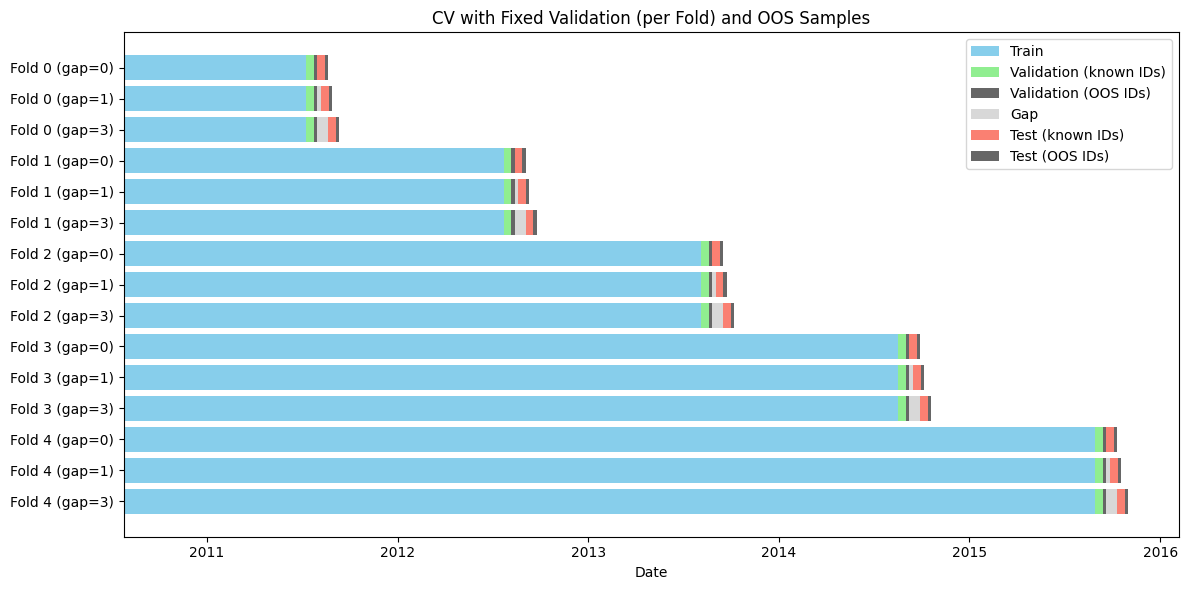

In [218]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import lightgbm as lgb
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Simulate data (same setup as before)
# [insert data simulation from earlier code here...]

# Plot function (from your original example)
# [insert `plot_cv_windows_val_fixed` function here...]

# Model training and evaluation loop
# [insert LGBM + TimeSeriesSplit loop from earlier...]

# Finally:
plot_cv_windows_val_fixed(results_df, horizon=3, val_len=3, oos_fraction=0.3)


In [160]:
import optuna
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
import polars as pl
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# Full CV function with LightGBM, validation, test (OOS), and parameter support
def run_polars_grouped_cv_with_val_lgbm(
    pl_df, group_col, date_col, value_col,
    train_size, val_size, test_size, gaps, n_splits, lgbm_params
):
    results = []
    unique_dates = pl_df.select(date_col).unique().sort(date_col)[date_col].to_numpy()
    group_ids = pl_df.select(group_col).unique().to_series().to_list()

    for gap in gaps:
        for fold in range(n_splits):
            train_start = fold
            train_end = train_start + train_size
            val_end = train_end + val_size
            test_start = val_end + gap
            test_end = test_start + test_size

            if test_end > len(unique_dates):
                break

            train_dates = set(unique_dates[train_start:train_end])
            val_dates = set(unique_dates[train_end:val_end])
            test_dates = set(unique_dates[test_start:test_end])

            for group in group_ids:
                group_df = pl_df.filter(pl.col(group_col) == group).sort(date_col)
                group_dates = group_df[date_col].to_numpy()

                train_mask = np.isin(group_dates, list(train_dates))
                val_mask = np.isin(group_dates, list(val_dates))
                test_mask = np.isin(group_dates, list(test_dates))

                train_df = group_df.filter(pl.Series(train_mask))
                val_df = group_df.filter(pl.Series(val_mask))
                test_df = group_df.filter(pl.Series(test_mask))

                if train_df.height < 5 or val_df.height == 0:
                    continue

                X_train = np.arange(train_df.height).reshape(-1, 1)
                y_train = train_df[value_col].to_numpy()
                X_val = np.arange(len(y_train), len(y_train) + len(val_df)).reshape(-1, 1)
                y_val = val_df[value_col].to_numpy()

                model = LGBMRegressor(**lgbm_params)
                model.fit(
                    X_train, y_train,
                    eval_set=[(X_val, y_val)],
                    callbacks=[early_stopping(stopping_rounds=lgbm_params.get("early_stopping_rounds", 10)),log_evaluation(0) ],
                )

                y_val_pred = model.predict(X_val)
                val_mse = mean_squared_error(y_val, y_val_pred)

                if test_df.height > 0:
                    X_test = np.arange(len(y_train) + len(y_val), len(y_train) + len(y_val) + test_df.height).reshape(-1, 1)
                    y_test = test_df[value_col].to_numpy()
                    y_test_pred = model.predict(X_test)
                    test_mse = mean_squared_error(y_test, y_test_pred)
                else:
                    test_mse = None

                results.append({
                    "group": group,
                    "fold": fold,
                    "gap": gap,
                    "val_mse": val_mse,
                    "test_mse": test_mse,
                    "val_len": val_df.height,
                    "test_len": test_df.height,
                    "train_len": train_df.height,
                    "train_start_date": train_df[date_col][0]
                })

    return pd.DataFrame(results)

# Optuna objective function
def objective(trial):
    lgbm_params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "num_leaves": trial.suggest_int("num_leaves", 16, 256),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 30),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "early_stopping_rounds": trial.suggest_int("early_stopping_rounds", 5, 30),
        "random_state": 42,
        "verbosity": -1
    }

    results_df = run_polars_grouped_cv_with_val_lgbm(
        pl_df=weekly_train,
        group_col="unique_id",
        date_col="ds",
        value_col="y",
        train_size=20,
        val_size=3,
        test_size=3,
        gaps=[0, 1, 3],
        n_splits=5,
        lgbm_params=lgbm_params
    )

    return results_df["val_mse"].mean()

# Run Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

best_params = study.best_params
best_score = study.best_value

best_params, best_score


[I 2025-06-14 16:19:26,261] A new study created in memory with name: no-name-356018b5-45a3-4223-bedf-d9f155bc51b4


Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 32737.9
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[167]	valid_0's l2: 3784.46
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 3025.62
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[2]	valid_0's l2: 3004.74
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[36]	valid_0's l2: 496.9
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 14766.1
Training u

[I 2025-06-14 16:19:34,952] Trial 0 finished with value: 212219.42088987047 and parameters: {'n_estimators': 167, 'learning_rate': 0.004738676788731264, 'max_depth': 10, 'num_leaves': 142, 'min_child_samples': 5, 'subsample': 0.5127638918270572, 'colsample_bytree': 0.6961554192404147, 'early_stopping_rounds': 20}. Best is trial 0 with value: 212219.42088987047.


Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 1741.83
Training until validation scores don't improve for 19 rounds
Training until validation scores don't improve for 19 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 32633.5
Training until validation scores don't improve for 19 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 14356.3
Training until validation scores don't improve for 19 rounds
Training until validation scores don't improve for 19 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 4331.08
Training until validation scores don't improve for 19 rounds
Training until validation scores don't improve for 19 rounds
Training until validation scores don't improve for 19 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 3005.57
Training until validation scores don't improve for 19 rounds
Early stopping, best ite

[I 2025-06-14 16:19:38,201] Trial 1 finished with value: 246561.45476904762 and parameters: {'n_estimators': 155, 'learning_rate': 0.05568229245863561, 'max_depth': 11, 'num_leaves': 86, 'min_child_samples': 24, 'subsample': 0.8352408006194556, 'colsample_bytree': 0.9702363508369239, 'early_stopping_rounds': 19}. Best is trial 0 with value: 212219.42088987047.


Training until validation scores don't improve for 19 rounds
Training until validation scores don't improve for 19 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 224316
Training until validation scores don't improve for 19 rounds
Training until validation scores don't improve for 19 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 1.07045e+06
Training until validation scores don't improve for 19 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 918978
Training until validation scores don't improve for 19 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 2.40346e+06
Training until validation scores don't improve for 19 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 97207.4
Training until validation scores don't improve for 19 rounds
Training until validation scores don't improve for 19 rounds
Training until validation scores don't improve for 19 rounds
Training until validation scores don't improve for 19 rounds
Early stopping, be

[I 2025-06-14 16:19:43,841] Trial 2 finished with value: 219247.81426261365 and parameters: {'n_estimators': 93, 'learning_rate': 0.022878373620865863, 'max_depth': 9, 'num_leaves': 129, 'min_child_samples': 9, 'subsample': 0.9629742551075803, 'colsample_bytree': 0.5172755838172536, 'early_stopping_rounds': 8}. Best is trial 0 with value: 212219.42088987047.


Did not meet early stopping. Best iteration is:
[93]	valid_0's l2: 757.498
Training until validation scores don't improve for 8 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 1776.3
Training until validation scores don't improve for 7 rounds
Training until validation scores don't improve for 7 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 39402.7
Training until validation scores don't improve for 7 rounds
Training until validation scores don't improve for 7 rounds
Early stopping, best iteration is:
[10]	valid_0's l2: 1933.81
Training until validation scores don't improve for 7 rounds
Did not meet early stopping. Best iteration is:
[243]	valid_0's l2: 3365.43
Training until validation scores don't improve for 7 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 6725.15
Training until validation scores don't improve for 7 rounds
Training until validation scores don't improve for 7 rounds
Training until validation scores don't improve for 7 rounds
Early

[I 2025-06-14 16:19:49,668] Trial 3 finished with value: 204082.48115717887 and parameters: {'n_estimators': 244, 'learning_rate': 0.2891079345775862, 'max_depth': 9, 'num_leaves': 22, 'min_child_samples': 5, 'subsample': 0.6457507344441824, 'colsample_bytree': 0.7061219404868591, 'early_stopping_rounds': 7}. Best is trial 3 with value: 204082.48115717887.


Training until validation scores don't improve for 7 rounds
Training until validation scores don't improve for 7 rounds
Training until validation scores don't improve for 7 rounds
Early stopping, best iteration is:
[27]	valid_0's l2: 7541.69
Training until validation scores don't improve for 7 rounds
Training until validation scores don't improve for 7 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 63142.2
Training until validation scores don't improve for 7 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 740.469
Training until validation scores don't improve for 7 rounds
Training until validation scores don't improve for 7 rounds
Training until validation scores don't improve for 7 rounds
Early stopping, best iteration is:
[11]	valid_0's l2: 33822.6
Training until validation scores don't improve for 7 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 1371.96
Training until validation scores don't improve for 7 rounds
Early stopping, best iteration is

[I 2025-06-14 16:19:58,256] Trial 4 finished with value: 196735.2486645736 and parameters: {'n_estimators': 224, 'learning_rate': 0.015124481955846356, 'max_depth': 3, 'num_leaves': 161, 'min_child_samples': 5, 'subsample': 0.7376274618878977, 'colsample_bytree': 0.7841679302300525, 'early_stopping_rounds': 5}. Best is trial 4 with value: 196735.2486645736.


Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 21 rounds
Training until validation scores don't improve for 21 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 32633.5
Training until validation scores don't improve for 21 rounds
Training until validation scores don't improve for 21 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 1974.09
Training until validation scores don't improve for 21 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 4331.08
Training until validation scores don't improve for 21 rounds
Training until validation scores don't improve for 21 rounds
Training until validation scores don't improve for 21 rounds
Training until validation scores don't improve for 21 rounds
Training until validation scores don't improve for 21 rounds
Training until validation scores don't improve for 21 rounds
Training until validation scores don't improve for 21 rounds
Early stopping, best iter

[I 2025-06-14 16:20:01,586] Trial 5 finished with value: 246561.45476904762 and parameters: {'n_estimators': 67, 'learning_rate': 0.0018021628422985978, 'max_depth': 8, 'num_leaves': 242, 'min_child_samples': 20, 'subsample': 0.9493768561670557, 'colsample_bytree': 0.6908903797810958, 'early_stopping_rounds': 21}. Best is trial 4 with value: 196735.2486645736.


Training until validation scores don't improve for 21 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 55570.2
Training until validation scores don't improve for 21 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 1104.62
Training until validation scores don't improve for 21 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 18117.3
Training until validation scores don't improve for 21 rounds
Training until validation scores don't improve for 21 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 53494.5
Training until validation scores don't improve for 21 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 1267.2
Training until validation scores don't improve for 21 rounds
Training until validation scores don't improve for 21 rounds
Training until validation scores don't improve for 21 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 327.477
Training until validation scores don't improve for 21 rounds
Training until validation

[I 2025-06-14 16:20:04,985] Trial 6 finished with value: 246561.45476904762 and parameters: {'n_estimators': 64, 'learning_rate': 0.003681100472642162, 'max_depth': 11, 'num_leaves': 253, 'min_child_samples': 16, 'subsample': 0.7374003999570143, 'colsample_bytree': 0.8762385470921231, 'early_stopping_rounds': 26}. Best is trial 4 with value: 196735.2486645736.


Training until validation scores don't improve for 13 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 32879.4
Training until validation scores don't improve for 13 rounds
Training until validation scores don't improve for 13 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 14356.3
Training until validation scores don't improve for 13 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 1974.09
Training until validation scores don't improve for 13 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 4331.08
Training until validation scores don't improve for 13 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 2990.84
Training until validation scores don't improve for 13 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 5623.44
Training until validation scores don't improve for 13 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 3005.57
Training until validation scores don't improve for 13 rounds
Training until validatio

[I 2025-06-14 16:20:08,046] Trial 7 finished with value: 246561.45476904762 and parameters: {'n_estimators': 291, 'learning_rate': 0.19219816534222922, 'max_depth': 3, 'num_leaves': 77, 'min_child_samples': 16, 'subsample': 0.6876973926531063, 'colsample_bytree': 0.8546323093254373, 'early_stopping_rounds': 13}. Best is trial 4 with value: 196735.2486645736.


Training until validation scores don't improve for 13 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 24154.5
Training until validation scores don't improve for 13 rounds
Training until validation scores don't improve for 13 rounds
Training until validation scores don't improve for 13 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 164643
Training until validation scores don't improve for 13 rounds
Training until validation scores don't improve for 13 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 143144
Training until validation scores don't improve for 13 rounds
Training until validation scores don't improve for 13 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 511801
Training until validation scores don't improve for 13 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 847.123
Training until validation scores don't improve for 13 rounds
Training until validation scores don't improve for 13 rounds
Early stopping, best iterat

[I 2025-06-14 16:20:11,146] Trial 8 finished with value: 246561.45476904762 and parameters: {'n_estimators': 180, 'learning_rate': 0.12409900688561568, 'max_depth': 6, 'num_leaves': 193, 'min_child_samples': 30, 'subsample': 0.8323904959444992, 'colsample_bytree': 0.9530486121168529, 'early_stopping_rounds': 18}. Best is trial 4 with value: 196735.2486645736.


Training until validation scores don't improve for 13 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 32879.4
Training until validation scores don't improve for 13 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 32633.5
Training until validation scores don't improve for 13 rounds
Training until validation scores don't improve for 13 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 1974.09
Training until validation scores don't improve for 13 rounds
Training until validation scores don't improve for 13 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 2990.84
Training until validation scores don't improve for 13 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 5623.44
Training until validation scores don't improve for 13 rounds
Training until validation scores don't improve for 13 rounds
Training until validation scores don't improve for 13 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 14736.4
Training until validatio

[I 2025-06-14 16:20:14,148] Trial 9 finished with value: 246561.45476904762 and parameters: {'n_estimators': 96, 'learning_rate': 0.06652004191507668, 'max_depth': 8, 'num_leaves': 82, 'min_child_samples': 15, 'subsample': 0.500864010592813, 'colsample_bytree': 0.8697964352200569, 'early_stopping_rounds': 13}. Best is trial 4 with value: 196735.2486645736.


Training until validation scores don't improve for 13 rounds
Training until validation scores don't improve for 13 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 57305.6
Training until validation scores don't improve for 13 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 224316
Training until validation scores don't improve for 13 rounds
Training until validation scores don't improve for 13 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 1.07045e+06
Training until validation scores don't improve for 13 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 918978
Training until validation scores don't improve for 13 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 2.40346e+06
Training until validation scores don't improve for 13 rounds
Training until validation scores don't improve for 13 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 1.02124e+06
Training until validation scores don't improve for 13 rounds
Training until

[I 2025-06-14 16:20:22,829] Trial 10 finished with value: 216912.99625653075 and parameters: {'n_estimators': 231, 'learning_rate': 0.01587270118197371, 'max_depth': 3, 'num_leaves': 183, 'min_child_samples': 10, 'subsample': 0.6049244557201715, 'colsample_bytree': 0.5711243549610042, 'early_stopping_rounds': 5}. Best is trial 4 with value: 196735.2486645736.


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[231]	valid_0's l2: 31047.1
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[231]	valid_0's l2: 227.731
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[231]	valid_0's l2: 5492.67
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[231]	valid_0's l2: 355.058
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[111]	valid_0's l2: 966.889
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[231]	valid_0's l2: 3050.47
Training until va

[I 2025-06-14 16:20:31,783] Trial 11 finished with value: 196403.59537642446 and parameters: {'n_estimators': 248, 'learning_rate': 0.014602598149194465, 'max_depth': 6, 'num_leaves': 20, 'min_child_samples': 5, 'subsample': 0.65454288053216, 'colsample_bytree': 0.7521966094431641, 'early_stopping_rounds': 9}. Best is trial 11 with value: 196403.59537642446.


Training until validation scores don't improve for 9 rounds
Did not meet early stopping. Best iteration is:
[247]	valid_0's l2: 34084.9
Training until validation scores don't improve for 9 rounds
Training until validation scores don't improve for 9 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 13348.1
Training until validation scores don't improve for 9 rounds
Did not meet early stopping. Best iteration is:
[248]	valid_0's l2: 5776.12
Training until validation scores don't improve for 9 rounds
Training until validation scores don't improve for 9 rounds
Training until validation scores don't improve for 9 rounds
Did not meet early stopping. Best iteration is:
[247]	valid_0's l2: 201.531
Training until validation scores don't improve for 9 rounds
Training until validation scores don't improve for 9 rounds
Did not meet early stopping. Best iteration is:
[248]	valid_0's l2: 2602.7
Training until validation scores don't improve for 9 rounds
Training until validation scores don

[I 2025-06-14 16:20:41,565] Trial 12 finished with value: 217149.93012107632 and parameters: {'n_estimators': 240, 'learning_rate': 0.013212943447694076, 'max_depth': 5, 'num_leaves': 18, 'min_child_samples': 10, 'subsample': 0.7983299496100237, 'colsample_bytree': 0.7829176096080541, 'early_stopping_rounds': 11}. Best is trial 11 with value: 196403.59537642446.


Training until validation scores don't improve for 11 rounds
Training until validation scores don't improve for 11 rounds
Did not meet early stopping. Best iteration is:
[240]	valid_0's l2: 31227.8
Training until validation scores don't improve for 11 rounds
Early stopping, best iteration is:
[14]	valid_0's l2: 1238.23
Training until validation scores don't improve for 11 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 13325.3
Training until validation scores don't improve for 11 rounds
Did not meet early stopping. Best iteration is:
[240]	valid_0's l2: 6629.21
Training until validation scores don't improve for 11 rounds
Training until validation scores don't improve for 11 rounds
Did not meet early stopping. Best iteration is:
[240]	valid_0's l2: 5505.35
Training until validation scores don't improve for 11 rounds
Training until validation scores don't improve for 11 rounds
Training until validation scores don't improve for 11 rounds
Did not meet early stopping. Best itera

[I 2025-06-14 16:20:53,554] Trial 13 finished with value: 218613.16923660578 and parameters: {'n_estimators': 292, 'learning_rate': 0.007305340881117739, 'max_depth': 5, 'num_leaves': 148, 'min_child_samples': 8, 'subsample': 0.5747244304030066, 'colsample_bytree': 0.778423503486275, 'early_stopping_rounds': 10}. Best is trial 11 with value: 196403.59537642446.


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 32879.4
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 14356.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 1974.09
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 4331.08
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 3005.57
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 14736.4
Training until validation scores d

[I 2025-06-14 16:20:56,895] Trial 14 finished with value: 246561.45476904762 and parameters: {'n_estimators': 208, 'learning_rate': 0.0361380411322834, 'max_depth': 6, 'num_leaves': 204, 'min_child_samples': 13, 'subsample': 0.7261940229803906, 'colsample_bytree': 0.6227975602540704, 'early_stopping_rounds': 5}. Best is trial 11 with value: 196403.59537642446.


Early stopping, best iteration is:
[1]	valid_0's l2: 14472.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 327.477
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 6283.69
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 862.722
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 5759.62
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 1092.16
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 15 rounds
Training until validation scores don't improve for 15 rounds
Training until validation scores don't improve for 15 rounds
Training until validation score

[I 2025-06-14 16:21:00,087] Trial 15 finished with value: 246561.45476904762 and parameters: {'n_estimators': 267, 'learning_rate': 0.0010938346041412213, 'max_depth': 4, 'num_leaves': 53, 'min_child_samples': 21, 'subsample': 0.6682143993279146, 'colsample_bytree': 0.809776701339761, 'early_stopping_rounds': 15}. Best is trial 11 with value: 196403.59537642446.


Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 1.07045e+06
Training until validation scores don't improve for 15 rounds
Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 2.40346e+06
Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 97207.4
Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 1.02124e+06
Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 3.52301e+06
Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 13701.8
Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 16703.6
Training until validation scores don't improve for 15 rounds
Training

[I 2025-06-14 16:21:10,902] Trial 16 finished with value: 200470.43694754443 and parameters: {'n_estimators': 208, 'learning_rate': 0.008173634060547842, 'max_depth': 6, 'num_leaves': 115, 'min_child_samples': 5, 'subsample': 0.889811653976906, 'colsample_bytree': 0.6268364180209868, 'early_stopping_rounds': 30}. Best is trial 11 with value: 196403.59537642446.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[35]	valid_0's l2: 729.6
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[208]	valid_0's l2: 10222.4
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 3900.8
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[208]	valid_0's l2: 37091.6
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[12]	valid_0's l2: 1238.24
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 13332.9
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[208]	valid_0's l2: 6359
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[102]	val

[I 2025-06-14 16:21:14,470] Trial 17 finished with value: 246561.45476904762 and parameters: {'n_estimators': 139, 'learning_rate': 0.029499244422995806, 'max_depth': 4, 'num_leaves': 157, 'min_child_samples': 13, 'subsample': 0.7804695777875227, 'colsample_bytree': 0.736640941315728, 'early_stopping_rounds': 9}. Best is trial 11 with value: 196403.59537642446.


Training until validation scores don't improve for 9 rounds
Training until validation scores don't improve for 9 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 1125.23
Training until validation scores don't improve for 9 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 5759.62
Training until validation scores don't improve for 9 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 1092.16
Training until validation scores don't improve for 9 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 33216.2
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[203]	valid_0's l2: 10188
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Training until validation scores don't improve for 5 rounds
Early stopping, best i

[I 2025-06-14 16:21:23,991] Trial 18 finished with value: 218776.14454555142 and parameters: {'n_estimators': 203, 'learning_rate': 0.010438439329798961, 'max_depth': 4, 'num_leaves': 108, 'min_child_samples': 8, 'subsample': 0.5804824011346627, 'colsample_bytree': 0.9146060189904355, 'early_stopping_rounds': 5}. Best is trial 11 with value: 196403.59537642446.


Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 32879.4
Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 32633.5
Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 14356.3
Training until validation scores don't improve for 15 rounds
Training until validation scores don't improve for 15 rounds
Training until validation scores don't improve for 15 rounds
Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 5623.44
Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 3005.57
Training until validation scores don't improve for 15 rounds
Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 14736.4
Training until validatio

[I 2025-06-14 16:21:27,573] Trial 19 finished with value: 246561.45476904762 and parameters: {'n_estimators': 269, 'learning_rate': 0.0031245200591902174, 'max_depth': 7, 'num_leaves': 168, 'min_child_samples': 27, 'subsample': 0.706495011783603, 'colsample_bytree': 0.8271700067529224, 'early_stopping_rounds': 15}. Best is trial 11 with value: 196403.59537642446.


Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 3888.76
Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 53494.5
Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 1267.2
Training until validation scores don't improve for 15 rounds
Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 14472.4
Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 327.477
Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 6283.69
Training until validation scores don't improve for 15 rounds
Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 1125.23
Training until validation

[I 2025-06-14 16:21:31,332] Trial 20 finished with value: 246561.45476904762 and parameters: {'n_estimators': 130, 'learning_rate': 0.06408714308298259, 'max_depth': 12, 'num_leaves': 216, 'min_child_samples': 13, 'subsample': 0.6302324023608855, 'colsample_bytree': 0.631676404726194, 'early_stopping_rounds': 23}. Best is trial 11 with value: 196403.59537642446.


Training until validation scores don't improve for 23 rounds
Training until validation scores don't improve for 23 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 41092.7
Training until validation scores don't improve for 23 rounds
Training until validation scores don't improve for 23 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 29146.2
Training until validation scores don't improve for 23 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 31626.1
Training until validation scores don't improve for 23 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 6908.29
Training until validation scores don't improve for 23 rounds
Training until validation scores don't improve for 23 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 10537.4
Training until validation scores don't improve for 23 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 15203.6
Training until validation scores don't improve for 23 rounds
Early stopping, best ite

[I 2025-06-14 16:21:41,961] Trial 21 finished with value: 201741.60878127586 and parameters: {'n_estimators': 206, 'learning_rate': 0.0072750993286858495, 'max_depth': 6, 'num_leaves': 123, 'min_child_samples': 6, 'subsample': 0.8958716215839178, 'colsample_bytree': 0.6503678569857183, 'early_stopping_rounds': 30}. Best is trial 11 with value: 196403.59537642446.


Training until validation scores don't improve for 26 rounds
Training until validation scores don't improve for 26 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 32797.4
Training until validation scores don't improve for 26 rounds
Training until validation scores don't improve for 26 rounds
Early stopping, best iteration is:
[81]	valid_0's l2: 1686.22
Training until validation scores don't improve for 26 rounds
Training until validation scores don't improve for 26 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 3045.8
Training until validation scores don't improve for 26 rounds
Training until validation scores don't improve for 26 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 3004.67
Training until validation scores don't improve for 26 rounds
Early stopping, best iteration is:
[23]	valid_0's l2: 496.918
Training until validation scores don't improve for 26 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 14786.8
Training until validati

[I 2025-06-14 16:21:51,893] Trial 22 finished with value: 201843.16918035195 and parameters: {'n_estimators': 223, 'learning_rate': 0.007434033654507942, 'max_depth': 7, 'num_leaves': 48, 'min_child_samples': 7, 'subsample': 0.9222452273155204, 'colsample_bytree': 0.7517386201878752, 'early_stopping_rounds': 26}. Best is trial 11 with value: 196403.59537642446.


Training until validation scores don't improve for 26 rounds
Training until validation scores don't improve for 26 rounds
Did not meet early stopping. Best iteration is:
[223]	valid_0's l2: 13323
Training until validation scores don't improve for 26 rounds
Early stopping, best iteration is:
[31]	valid_0's l2: 3718.09
Training until validation scores don't improve for 26 rounds
Did not meet early stopping. Best iteration is:
[223]	valid_0's l2: 32788
Training until validation scores don't improve for 26 rounds
Training until validation scores don't improve for 26 rounds
Training until validation scores don't improve for 26 rounds
Training until validation scores don't improve for 26 rounds
Training until validation scores don't improve for 26 rounds
Training until validation scores don't improve for 26 rounds
Did not meet early stopping. Best iteration is:
[223]	valid_0's l2: 244.4
Training until validation scores don't improve for 26 rounds
Early stopping, best iteration is:
[97]	valid

[I 2025-06-14 16:21:55,762] Trial 23 finished with value: 246561.45476904762 and parameters: {'n_estimators': 263, 'learning_rate': 0.018889744765516855, 'max_depth': 5, 'num_leaves': 107, 'min_child_samples': 11, 'subsample': 0.8739829779820355, 'colsample_bytree': 0.5799852884867989, 'early_stopping_rounds': 28}. Best is trial 11 with value: 196403.59537642446.


Training until validation scores don't improve for 28 rounds
Training until validation scores don't improve for 28 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 97207.4
Training until validation scores don't improve for 28 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 1.02124e+06
Training until validation scores don't improve for 28 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 3.52301e+06
Training until validation scores don't improve for 28 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 13701.8
Training until validation scores don't improve for 28 rounds
Training until validation scores don't improve for 28 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 41092.7
Training until validation scores don't improve for 28 rounds
Training until validation scores don't improve for 28 rounds
Training until validation scores don't improve for 28 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 31626.1
Training until v

[I 2025-06-14 16:22:04,967] Trial 24 finished with value: 198926.25905443128 and parameters: {'n_estimators': 193, 'learning_rate': 0.010729912538879342, 'max_depth': 3, 'num_leaves': 51, 'min_child_samples': 5, 'subsample': 0.9884230903160796, 'colsample_bytree': 0.7485629196294706, 'early_stopping_rounds': 23}. Best is trial 11 with value: 196403.59537642446.


Training until validation scores don't improve for 23 rounds
Did not meet early stopping. Best iteration is:
[193]	valid_0's l2: 2865.36
Training until validation scores don't improve for 23 rounds
Did not meet early stopping. Best iteration is:
[193]	valid_0's l2: 681.664
Training until validation scores don't improve for 23 rounds
Training until validation scores don't improve for 23 rounds
Training until validation scores don't improve for 23 rounds
Training until validation scores don't improve for 23 rounds
Did not meet early stopping. Best iteration is:
[188]	valid_0's l2: 9758.05
Training until validation scores don't improve for 23 rounds
Training until validation scores don't improve for 23 rounds
Did not meet early stopping. Best iteration is:
[188]	valid_0's l2: 4257.97
Training until validation scores don't improve for 23 rounds
Training until validation scores don't improve for 23 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 5854.05
Training until validation

[I 2025-06-14 16:22:13,781] Trial 25 finished with value: 217604.19816869285 and parameters: {'n_estimators': 188, 'learning_rate': 0.04399533861991676, 'max_depth': 3, 'num_leaves': 43, 'min_child_samples': 8, 'subsample': 0.7653678949029372, 'colsample_bytree': 0.7486433720234846, 'early_stopping_rounds': 23}. Best is trial 11 with value: 196403.59537642446.


Training until validation scores don't improve for 7 rounds
Training until validation scores don't improve for 7 rounds
Training until validation scores don't improve for 7 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 14356.3
Training until validation scores don't improve for 7 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 1974.09
Training until validation scores don't improve for 7 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 4331.08
Training until validation scores don't improve for 7 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 2990.84
Training until validation scores don't improve for 7 rounds
Training until validation scores don't improve for 7 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 3005.57
Training until validation scores don't improve for 7 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 907.627
Training until validation scores don't improve for 7 rounds
Early stopping, best iteration is:

[I 2025-06-14 16:22:17,179] Trial 26 finished with value: 246561.45476904762 and parameters: {'n_estimators': 256, 'learning_rate': 0.020888298935298664, 'max_depth': 4, 'num_leaves': 68, 'min_child_samples': 11, 'subsample': 0.9940827830886603, 'colsample_bytree': 0.8101339233969638, 'early_stopping_rounds': 7}. Best is trial 11 with value: 196403.59537642446.


Training until validation scores don't improve for 7 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 718.336
Training until validation scores don't improve for 7 rounds
Training until validation scores don't improve for 7 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 282.223
Training until validation scores don't improve for 7 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 40.3567
Training until validation scores don't improve for 7 rounds
Training until validation scores don't improve for 7 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 65518.1
Training until validation scores don't improve for 7 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 74028.2
Training until validation scores don't improve for 7 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 319116
Training until validation scores don't improve for 7 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 16145
Training until validation scores don

[I 2025-06-14 16:22:26,824] Trial 27 finished with value: 207177.581569405 and parameters: {'n_estimators': 223, 'learning_rate': 0.004839791206231066, 'max_depth': 3, 'num_leaves': 31, 'min_child_samples': 7, 'subsample': 0.8457447942409566, 'colsample_bytree': 0.7234732999232476, 'early_stopping_rounds': 16}. Best is trial 11 with value: 196403.59537642446.


Training until validation scores don't improve for 12 rounds
Training until validation scores don't improve for 12 rounds
Training until validation scores don't improve for 12 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 14356.3
Training until validation scores don't improve for 12 rounds
Training until validation scores don't improve for 12 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 4331.08
Training until validation scores don't improve for 12 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 2990.84
Training until validation scores don't improve for 12 rounds
Training until validation scores don't improve for 12 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 3005.57
Training until validation scores don't improve for 12 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 907.627
Training until validation scores don't improve for 12 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 14736.4
Training until validatio

[I 2025-06-14 16:22:30,470] Trial 28 finished with value: 246561.45476904762 and parameters: {'n_estimators': 187, 'learning_rate': 0.014047324335060703, 'max_depth': 5, 'num_leaves': 97, 'min_child_samples': 20, 'subsample': 0.8026340928636515, 'colsample_bytree': 0.6674513335033567, 'early_stopping_rounds': 12}. Best is trial 11 with value: 196403.59537642446.


Training until validation scores don't improve for 12 rounds
Training until validation scores don't improve for 12 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 224316
Training until validation scores don't improve for 12 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 8931.77
Training until validation scores don't improve for 12 rounds
Training until validation scores don't improve for 12 rounds
Training until validation scores don't improve for 12 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 2.40346e+06
Training until validation scores don't improve for 12 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 97207.4
Training until validation scores don't improve for 12 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 1.02124e+06
Training until validation scores don't improve for 12 rounds
Training until validation scores don't improve for 12 rounds
Training until validation scores don't improve for 12 rounds
Early stopping, b

[I 2025-06-14 16:22:39,823] Trial 29 finished with value: 211754.30487342703 and parameters: {'n_estimators': 164, 'learning_rate': 0.004949832273236451, 'max_depth': 4, 'num_leaves': 58, 'min_child_samples': 5, 'subsample': 0.5397862129330386, 'colsample_bytree': 0.6809076925671893, 'early_stopping_rounds': 21}. Best is trial 11 with value: 196403.59537642446.


({'n_estimators': 248,
  'learning_rate': 0.014602598149194465,
  'max_depth': 6,
  'num_leaves': 20,
  'min_child_samples': 5,
  'subsample': 0.65454288053216,
  'colsample_bytree': 0.7521966094431641,
  'early_stopping_rounds': 9},
 196403.59537642446)

In [161]:

best_params = study.best_params
best_score = study.best_value

best_params, best_score

({'n_estimators': 248,
  'learning_rate': 0.014602598149194465,
  'max_depth': 6,
  'num_leaves': 20,
  'min_child_samples': 5,
  'subsample': 0.65454288053216,
  'colsample_bytree': 0.7521966094431641,
  'early_stopping_rounds': 9},
 196403.59537642446)

In [ ]:
weekly_train_pd = weekly_train.to_pandas()

In [ ]:
weekly_train_pd = weekly_train_pd.loc[lambda df: df["week_end"].isin(pd.Series(df["week_end"].unique()).sort_values().tail(34*4))]

In [ ]:
weekly_train_pd["eval"] = weekly_train_pd["week_end"].isin(pd.Series(weekly_train_pd["week_end"].unique()).sort_values().tail(6*4))

In [ ]:
weekly_train_pd

item_id      dept_id     cat_id store_id state_id   week_end  \
1            FOODS_1_195      FOODS_1      FOODS     CA_3       CA 2013-10-13   
4            FOODS_3_583      FOODS_3      FOODS     CA_1       CA 2014-05-18   
6        HOUSEHOLD_1_228  HOUSEHOLD_1  HOUSEHOLD     TX_3       TX 2015-02-01   
11           FOODS_2_360      FOODS_2      FOODS     CA_3       CA 2014-08-03   
12           FOODS_3_807      FOODS_3      FOODS     CA_2       CA 2013-12-08   
...                  ...          ...        ...      ...      ...        ...   
8384742      FOODS_1_107      FOODS_1      FOODS     WI_1       WI 2013-11-10   
8384744      FOODS_3_813      FOODS_3      FOODS     CA_3       CA 2015-02-08   
8384747      FOODS_3_294      FOODS_3      FOODS     TX_1       TX 2014-03-23   
8384748      FOODS_3_083      FOODS_3      FOODS     CA_3       CA 2014-06-08   
8384749    HOBBIES_2_066    HOBBIES_2    HOBBIES     TX_2       TX 2015-01-11   

         value   eval  
1            0  False  
4           19  False  
6            7  False  
11         173  False  
12          23  False  
...        ...    ...  
8384742      3  False  
8384744      9  False  
8384747     17  False  
8384748     39  False  
8384749      1  False  

[4146640 rows x 8 columns]

In [ ]:
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from mlforecast import MLForecast
from mlforecast.lag_transforms import RollingMean, ExpandingMean
from mlforecast.target_transforms import Differences

# Constants
TRAIN_WEEKS = 104
HORIZON = 4
MAX_GAP = 26
MAX_SHIFT = 26
MAX_TRAIN_ROWS = 100_000

# Mark evaluation period (6 months)
weekly_train_pd["eval"] = weekly_train_pd["week_end"].isin(
    pd.Series(weekly_train_pd["week_end"].unique()).sort_values().tail(6 * 4)
)

weekly_train_pd["unique_id"] = weekly_train_pd["item_id"].astype(str)
weekly_train_pd = weekly_train_pd.rename(columns={"week_end": "ds", "value": "y"})

train_series = weekly_train_pd[~weekly_train_pd["eval"]].copy()
eval_series = weekly_train_pd[weekly_train_pd["eval"]].copy()

levels = ["dept_id", "cat_id", "store_id", "state_id", "all"]

# Model storage dictionary
models = {}

# 1️⃣ TRAINING PHASE
for level in levels:
    print(f"\n=== Training Phase: Level {level} ===")
    if level == "all":
        unique_groups = ["all"]
    else:
        unique_groups = weekly_train_pd[level].unique()

    for group in unique_groups:
        print(f"Training model for group {group} at level {level}...")
        if level == "all":
            df_train = train_series.copy()
        else:
            df_train = train_series[train_series[level] == group].copy()

        group_unique_ids = df_train["unique_id"].unique()
        if len(group_unique_ids) == 0:
            continue

        # Sample training data by unique_id (preserve sequences)
        if len(df_train) > MAX_TRAIN_ROWS:
            unique_ids = df_train["unique_id"].unique()
            np.random.seed(42)
            np.random.shuffle(unique_ids)
            selected_ids = []
            current_count = 0
            for uid in unique_ids:
                uid_rows = df_train[df_train["unique_id"] == uid]
                n_rows = len(uid_rows)
                if current_count + n_rows > MAX_TRAIN_ROWS:
                    break
                selected_ids.append(uid)
                current_count += n_rows
            df_train = df_train[df_train["unique_id"].isin(selected_ids)].copy()

        df_train = df_train[["unique_id", "ds", "y"]].copy()
        model = LGBMRegressor(num_leaves=31, learning_rate=0.05, n_estimators=200, min_child_samples=20, verbose=-1)
        fcst = MLForecast(
            models=[model],
            freq='W-SUN',
            lags=[1, 2],
            lag_transforms={
                1: [ExpandingMean()],
                2: [RollingMean(window_size=4)]
            },
            target_transforms=[Differences([1])]
        )

        try:
            fcst.fit(df_train)
            models[(level, group)] = fcst
        except Exception as e:
            print(f"Failed to train model for group {group} at level {level}. Skipping. Error: {e}")



=== Training Phase: Level dept_id ===
Training model for group FOODS_1 at level dept_id...
Training model for group FOODS_3 at level dept_id...
Training model for group HOUSEHOLD_1 at level dept_id...
Training model for group FOODS_2 at level dept_id...
Training model for group HOBBIES_1 at level dept_id...
Training model for group HOUSEHOLD_2 at level dept_id...
Training model for group HOBBIES_2 at level dept_id...

=== Training Phase: Level cat_id ===
Training model for group FOODS at level cat_id...
Training model for group HOUSEHOLD at level cat_id...
Training model for group HOBBIES at level cat_id...

=== Training Phase: Level store_id ===
Training model for group CA_3 at level store_id...
Training model for group CA_1 at level store_id...
Training model for group TX_3 at level store_id...
Training model for group CA_2 at level store_id...
Training model for group TX_1 at level store_id...
Training model for group WI_2 at level store_id...
Training model for group CA_4 at level

KeyboardInterrupt: 

In [ ]:
# 2️⃣ EVALUATION PHASE
all_forecasts_raw = []
all_forecasts_merged = []
results = []
latest_date = eval_series["ds"].max()

# Set consistent random seed once globally
np.random.seed(42)
gap_weeks = np.random.randint(0, MAX_GAP + 1)
shift_weeks = np.random.randint(-MAX_SHIFT, MAX_SHIFT + 1)

print(f"Using consistent gap_weeks: {gap_weeks} and shift_weeks: {shift_weeks} for all groups.")

for level in levels:
    print(f"\n=== Evaluation Phase: Level {level} ===")
    if level == "all":
        unique_groups = ["all"]
    else:
        unique_groups = weekly_train_pd[level].unique()

    for group in unique_groups:
        model_key = (level, group)
        if model_key not in models:
            print(f"Model for group {group} at level {level} not found. Skipping.")
            continue

        fcst = models[model_key]

        if level == "all":
            df_eval = eval_series.copy()
            df_train = train_series.copy()
        else:
            df_eval = eval_series[eval_series[level] == group].copy()
            df_train = train_series[train_series[level] == group].copy()

        if df_eval.empty or df_train.empty:
            continue

        group_max_train_end = df_train.groupby("unique_id")["ds"].max().max()
        max_gap_allowed = ((latest_date - group_max_train_end).days // 7) - HORIZON - 1
        if max_gap_allowed < 0:
            continue

        # Clip gap_weeks to maximum allowed
        gap_weeks_adj = min(gap_weeks, max_gap_allowed)

        val_start = group_max_train_end + pd.Timedelta(weeks=1 + gap_weeks_adj)
        val_end = val_start + pd.Timedelta(weeks=HORIZON - 1)

        val_df = df_eval[(df_eval["ds"] >= val_start) & (df_eval["ds"] <= val_end)].copy()
        if val_df.empty or val_df["ds"].nunique() < HORIZON:
            continue

        val_df["eval_ds"] = val_df["ds"]
        val_df["shifted_ds"] = val_df["ds"] + pd.to_timedelta(shift_weeks, unit="W")
        val_df["shifted_ds"] = val_df["shifted_ds"] + pd.offsets.Week(weekday=6)  # Align to Sunday
        val_df["ds"] = val_df["shifted_ds"]

        combined_df = pd.concat([df_train, val_df], axis=0, ignore_index=True)[["ds", "unique_id", "y"]]

        try:
            forecast_df = fcst.predict(h=HORIZON, new_df=combined_df)
            forecast_df = forecast_df.rename(columns={"LGBMRegressor": "forecast"})

            forecast_df["level"] = level
            forecast_df["group"] = group
            forecast_df["gap_weeks"] = gap_weeks_adj
            forecast_df["shift_weeks"] = shift_weeks
            forecast_df["train_start"] = df_train["ds"].min()
            forecast_df["train_end"] = df_train["ds"].max()
            all_forecasts_raw.append(forecast_df.copy())

            val_df["forecast_ds"] = val_df["ds"]
            val_merged = val_df.merge(
                forecast_df,
                how='left',
                left_on=['unique_id', 'forecast_ds'],
                right_on=['unique_id', 'ds']
            )

            if val_merged.empty or val_merged['forecast'].isnull().all():
                continue

            val_merged["level"] = level
            val_merged["group"] = group
            val_merged["gap_weeks"] = gap_weeks_adj
            val_merged["shift_weeks"] = shift_weeks
            val_merged["train_start"] = df_train["ds"].min()
            val_merged["train_end"] = df_train["ds"].max()
            all_forecasts_merged.append(val_merged.copy())

        except Exception as e:
            print(f"Prediction failed for group {group} at level {level}. Skipping. Error: {e}")
            continue

# Concatenate all forecasts
if all_forecasts_raw and all_forecasts_merged:
    raw_forecasts_df = pd.concat(all_forecasts_raw, ignore_index=True)
    merged_forecasts_df = pd.concat(all_forecasts_merged, ignore_index=True).dropna()

    # Calculate per-item RMSE
    item_rmses = (
        merged_forecasts_df.groupby(["level", "group", "unique_id"])
        .apply(lambda g: np.sqrt(mean_squared_error(g["y"], g["forecast"])))
        .reset_index()
        .rename(columns={0: "rmse"})
    )

    results_df = item_rmses.merge(
        merged_forecasts_df[["level", "group", "train_start", "train_end", "gap_weeks", "shift_weeks"]],
        on=["level", "group"],
        how="left"
    ).drop_duplicates(subset=["level", "group", "unique_id", "rmse"])

    print("\nPerformance Summary with Group-Level Models and Per-Item Evaluation:")
    print(results_df)
else:
    print("No forecasts generated.")


Using consistent gap_weeks: 6 and shift_weeks: 25 for all groups.

=== Evaluation Phase: Level dept_id ===

=== Evaluation Phase: Level cat_id ===

=== Evaluation Phase: Level store_id ===

=== Evaluation Phase: Level state_id ===

=== Evaluation Phase: Level all ===
No forecasts generated.


In [ ]:
results_df.groupby("level")["rmse"].describe()

count      mean       std       min       25%       50%       75%  \
level                                                                          
cat_id    1047.0  4.880928  5.824786  0.458879  1.802355  2.894126  5.249121   
store_id  9147.0  3.581698  8.593933  0.002059  0.820866  1.794714  3.597539   

                max  
level                
cat_id     49.17747  
store_id  417.43839

In [ ]:
raw_forecasts_df

unique_id         ds  forecast    level    group  gap_weeks  \
0           FOODS_1_001 2016-05-01  4.706403  dept_id  FOODS_1         17   
1           FOODS_1_001 2016-05-08  5.340689  dept_id  FOODS_1         17   
2           FOODS_1_001 2016-05-15  6.683623  dept_id  FOODS_1         17   
3           FOODS_1_001 2016-05-22  5.892852  dept_id  FOODS_1         17   
4           FOODS_1_002 2016-05-01  3.899232  dept_id  FOODS_1         17   
...                 ...        ...       ...      ...      ...        ...   
195131  HOUSEHOLD_2_515 2015-12-06  2.563720      all      all          9   
195132  HOUSEHOLD_2_516 2015-11-15  0.756355      all      all          9   
195133  HOUSEHOLD_2_516 2015-11-22  1.038510      all      all          9   
195134  HOUSEHOLD_2_516 2015-11-29  1.188728      all      all          9   
195135  HOUSEHOLD_2_516 2015-12-06  0.943693      all      all          9   

        shift_weeks train_start  train_end  
0                 3  2013-09-22 2015-11-08  
1                 3  2013-09-22 2015-11-08  
2                 3  2013-09-22 2015-11-08  
3                 3  2013-09-22 2015-11-08  
4                 3  2013-09-22 2015-11-08  
...             ...         ...        ...  
195131          -22  2013-09-22 2015-11-08  
195132          -22  2013-09-22 2015-11-08  
195133          -22  2013-09-22 2015-11-08  
195134          -22  2013-09-22 2015-11-08  
195135          -22  2013-09-22 2015-11-08  

[195136 rows x 9 columns]

In [ ]:
forecast_df

unique_id         ds  forecast
0          FOODS_1_001 2016-01-17  4.005589
1          FOODS_1_001 2016-01-24  3.540398
2          FOODS_1_001 2016-01-31  4.086569
3          FOODS_1_001 2016-02-07  4.035424
4          FOODS_1_002 2016-01-17  0.951707
...                ...        ...       ...
12191  HOUSEHOLD_2_515 2016-02-07  2.529111
12192  HOUSEHOLD_2_516 2016-01-17  1.702795
12193  HOUSEHOLD_2_516 2016-01-24  2.014312
12194  HOUSEHOLD_2_516 2016-01-31  1.418579
12195  HOUSEHOLD_2_516 2016-02-07  1.970726

[12196 rows x 3 columns]

In [ ]:
pd_results = pd.DataFrame(results)

In [ ]:
pd_results{}

level      group        item_id train_start  train_end  gap_weeks  \
0     dept_id    FOODS_2    FOODS_2_001  2013-09-22 2015-11-08          3   
1     dept_id    FOODS_2    FOODS_2_002  2013-09-22 2015-11-08          3   
2     dept_id    FOODS_2    FOODS_2_003  2013-09-22 2015-11-08          3   
3     dept_id    FOODS_2    FOODS_2_004  2013-09-22 2015-11-08          3   
4     dept_id    FOODS_2    FOODS_2_005  2013-09-22 2015-11-08          3   
...       ...        ...            ...         ...        ...        ...   
1057  dept_id  HOBBIES_2  HOBBIES_2_145  2013-09-22 2015-11-08          0   
1058  dept_id  HOBBIES_2  HOBBIES_2_146  2013-09-22 2015-11-08          0   
1059  dept_id  HOBBIES_2  HOBBIES_2_147  2013-09-22 2015-11-08          0   
1060  dept_id  HOBBIES_2  HOBBIES_2_148  2013-09-22 2015-11-08          0   
1061  dept_id  HOBBIES_2  HOBBIES_2_149  2013-09-22 2015-11-08          0   

      val_start    val_end  shift_weeks       rmse  
0    2015-12-06 2015-12-27          -15   7.340861  
1    2015-12-06 2015-12-27          -15  15.057573  
2    2015-12-06 2015-12-27          -15   5.006414  
3    2015-12-06 2015-12-27          -15   8.112376  
4    2015-12-06 2015-12-27          -15   4.647078  
...         ...        ...          ...        ...  
1057 2015-11-15 2015-12-06          -23   2.474624  
1058 2015-11-15 2015-12-06          -23   1.984080  
1059 2015-11-15 2015-12-06          -23   2.556683  
1060 2015-11-15 2015-12-06          -23   6.739307  
1061 2015-11-15 2015-12-06          -23   7.133536  

[1062 rows x 10 columns]

In [ ]:
pd_results.groupby(["group","train_start"])["rmse"].describe()

count      mean       std       min       25%  \
group       train_start                                                  
FOODS_2     2013-09-22   398.0  8.413203  8.764041  0.920949  3.657512   
HOBBIES_2   2013-09-22   149.0  2.688127  2.614278  0.628361  1.390869   
HOUSEHOLD_2 2013-09-22   515.0  2.526020  2.133442  0.455158  1.464658   

                              50%       75%        max  
group       train_start                                 
FOODS_2     2013-09-22   5.748006  9.458067  81.174702  
HOBBIES_2   2013-09-22   1.910033  2.706466  17.534963  
HOUSEHOLD_2 2013-09-22   2.013790  2.827434  29.728792

In [ ]:
forecast_df["level"].value_counts()

level
all    12196
Name: count, dtype: int64

In [ ]:
results

[]

In [ ]:
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from mlforecast import MLForecast
from mlforecast.lag_transforms import RollingMean, ExpandingMean
from mlforecast.target_transforms import Differences

# Constants
TRAIN_WEEKS = 104  # 24 months
HORIZON = 4
MAX_GAP = 26  # up to 6 months
MAX_SHIFT = 26  # up to 6 months
N_SPLITS = 2  # reduced for speed
MAX_TRAIN_ROWS = 100_000

# Dates and training data
global_first_date = weekly_train_pd['week_end'].min()
global_last_date = weekly_train_pd['week_end'].max()
total_weeks = (global_last_date - global_first_date).days // 7

train_start = global_first_date
train_end = train_start + pd.Timedelta(weeks=TRAIN_WEEKS - 1)

print(f"Total weeks: {total_weeks}, Training period: {train_start.date()} to {train_end.date()}")

weekly_train_pd['unique_id'] = weekly_train_pd['item_id'].astype(str)
train_series = weekly_train_pd.rename(columns={'week_end': 'ds', 'value': 'y'})[['unique_id', 'ds', 'y']]
train_series = train_series[(train_series['ds'] >= train_start) & (train_series['ds'] <= train_end)].copy()
train_series = train_series.rename(columns={'week_end': 'ds', 'value': 'y'})[['unique_id', 'ds', 'y']]

group_unique_ids = df['unique_id'].unique()

results = []

def process_group(split_idx, level, group, train_series, weekly_train_pd):
    group_results = []

    model = LGBMRegressor(num_leaves=31, learning_rate=0.05, n_estimators=200, min_child_samples=20,verbose=-1)

    if level == 'all':
        df = weekly_train_pd.copy()
    else:
        df = weekly_train_pd[weekly_train_pd[level] == group].copy()


    group_train_series = train_series[train_series['unique_id'].isin(group_unique_ids)].copy()
    if group_train_series.empty:
        return group_results

    # Sample training data if too large
    # Sample training data if too large
    if len(group_train_series) > MAX_TRAIN_ROWS:
        unique_ids = group_train_series['unique_id'].unique()
        # Shuffle unique_ids
        np.random.seed(42)
        np.random.shuffle(unique_ids)
        
        selected_ids = []
        current_count = 0
        for uid in unique_ids:
            uid_rows = group_train_series[group_train_series['unique_id'] == uid]
            n_rows = len(uid_rows)
            if current_count + n_rows > MAX_TRAIN_ROWS:
                break
            selected_ids.append(uid)
            current_count += n_rows
        
        group_train_series = group_train_series[group_train_series['unique_id'].isin(selected_ids)].copy()


    fcst = MLForecast(
        models=[model],
        freq='W-SUN',
        lags=[1, 2],
        lag_transforms={
            1: [ExpandingMean()],
            2: [RollingMean(window_size=4)]
        },
        target_transforms=[Differences([1])]
    )

    try:
        fcst.fit(group_train_series)
    except Exception as e:
        print(f"Failed to train model for group {group} at level {level}. Skipping.")
        return group_results

    forecast_df = fcst.predict(h=HORIZON)
    forecast_df = forecast_df.rename(columns={'LGBMRegressor': 'forecast'})

    for uid in group_unique_ids:
        uid_train_end = group_train_series[group_train_series['unique_id'] == uid]['ds'].max()
        if pd.isna(uid_train_end):
            continue

        gap_weeks = np.random.randint(0, MAX_GAP + 1)
        shift_weeks = np.random.randint(-MAX_SHIFT, MAX_SHIFT + 1)

        val_start = uid_train_end + pd.Timedelta(weeks=1 + gap_weeks)
        val_end = val_start + pd.Timedelta(weeks=HORIZON - 1)

        uid_val = df[(df['unique_id'] == uid) & (df['ds'] >= val_start) & (df['ds'] <= val_end)].copy()
        if uid_val.empty or len(uid_val) < HORIZON:
            continue

        uid_val['ds'] = uid_val['ds'] + pd.Timedelta(weeks=shift_weeks)

        uid_forecast = forecast_df[forecast_df['unique_id'] == uid].copy()

        val_merged = uid_val.merge(
            uid_forecast,
            how='left',
            on=['unique_id', 'ds']
        )

        if val_merged.empty or val_merged['forecast'].isnull().all():
            continue

        try:
            rmse = np.sqrt(mean_squared_error(val_merged['y'], val_merged['forecast']))
            group_results.append({
                'split_idx': split_idx + 1,
                'level': level,
                'group': group,
                'item_id': uid,
                'train_start': group_train_series['ds'].min(),
                'train_end': group_train_series['ds'].max(),
                'gap_weeks': gap_weeks,
                'val_start': val_start,
                'val_end': val_end,
                'shift_weeks': shift_weeks,
                'rmse': rmse
            })
        except Exception as e:
            continue

    return group_results

# Main loop sequentially
for split_idx in range(N_SPLITS):
    print(f"\nProcessing Split {split_idx+1}/{N_SPLITS}")

    for level in ['dept_id', 'cat_id', 'store_id', 'state_id', 'all']:
        print(f"Processing level: {level}")
        if level == 'all':
            unique_groups = ['all']
        else:
            unique_groups = weekly_train_pd[level].unique()

        for group in unique_groups:
            group_results = process_group(split_idx, level, group, train_series, weekly_train_pd)
            results.extend(group_results)

# Compile results
results_df = pd.DataFrame(results)
print("\nPerformance Summary with Group-Level Models and Per-Item Evaluation:")
print(results_df)


Total weeks: 274, Training period: 2011-01-23 to 2013-01-13

Processing Split 1/2
Processing level: dept_id
Processing level: cat_id
Processing level: store_id
Processing level: state_id
Processing level: all

Processing Split 2/2
Processing level: dept_id
Processing level: cat_id
Processing level: store_id
Processing level: state_id
Processing level: all

Performance Summary with Group-Level Models and Per-Item Evaluation:
     split_idx     level        group          item_id train_start  train_end  \
0            1   dept_id      FOODS_2      FOODS_2_319  2011-01-23 2013-01-13   
1            1   dept_id  HOUSEHOLD_2  HOUSEHOLD_2_389  2011-01-23 2013-01-13   
2            1   dept_id  HOUSEHOLD_1  HOUSEHOLD_1_281  2011-01-23 2013-01-13   
3            1   dept_id    HOBBIES_1    HOBBIES_1_310  2011-01-23 2013-01-13   
4            1   dept_id      FOODS_3      FOODS_3_595  2011-01-23 2013-01-13   
..         ...       ...          ...              ...         ...        ...   
105  

In [ ]:
results_df.groupby(['level'])["rmse"].describe()

count       mean        std       min       25%       50%  \
level                                                                 
all         6.0   9.964740  14.947749  0.316010  0.316010  0.316010   
cat_id      2.0   2.248667   0.000000  2.248667  2.248667  2.248667   
dept_id    24.0   3.008480   3.329417  0.320116  0.631655  1.875598   
state_id   18.0  10.915577  21.378525  0.316010  0.316010  1.112241   
store_id   60.0   8.952820  24.153778  0.316010  0.316010  2.691421   

                75%         max  
level                            
all       22.025653   29.262201  
cat_id     2.248667    2.248667  
dept_id    3.746045   12.475082  
state_id   5.082062   67.183492  
store_id   4.824882  131.830403

In [ ]:
group_unique_ids

NameError: name 'group_unique_ids' is not defined

In [ ]:
results_df["item_id"].value_counts()

item_id
FOODS_2_002        6
HOBBIES_1_260      6
FOODS_3_416        4
FOODS_2_125        4
FOODS_3_317        4
HOBBIES_2_039      4
FOODS_2_338        4
FOODS_2_319        2
HOUSEHOLD_1_334    2
FOODS_3_049        2
FOODS_2_208        2
FOODS_3_776        2
HOUSEHOLD_1_237    2
HOBBIES_1_367      2
HOBBIES_1_107      2
HOBBIES_1_109      2
FOODS_2_337        2
FOODS_2_311        2
HOUSEHOLD_2_128    2
FOODS_3_271        2
HOUSEHOLD_1_495    2
HOUSEHOLD_2_028    2
FOODS_3_318        2
FOODS_1_193        2
HOUSEHOLD_2_445    2
HOBBIES_1_183      2
FOODS_2_085        2
HOUSEHOLD_2_389    2
HOUSEHOLD_1_281    2
HOBBIES_1_310      2
FOODS_3_595        2
FOODS_3_611        2
FOODS_1_010        2
FOODS_1_095        2
FOODS_1_056        2
HOBBIES_2_041      2
HOBBIES_2_093      2
HOBBIES_2_137      2
HOBBIES_2_123      2
HOBBIES_1_113      2
FOODS_2_095        2
FOODS_3_806        2
FOODS_3_723        2
FOODS_3_373        2
HOUSEHOLD_2_450    2
HOBBIES_1_167      2
Name: count, dtype: int64

In [ ]:
TRAIN_WEEKS = 104  # 24 months
HORIZON = 4
MAX_GAP = 26  # up to 6 months
MAX_SHIFT = 26  # up to 6 months

results = []

global_first_date = weekly_train_pd['week_end'].min()
global_last_date = weekly_train_pd['week_end'].max()
total_weeks = (global_last_date - global_first_date).days // 7

n_splits = 5

train_start = global_first_date
train_end = train_start + pd.Timedelta(weeks=TRAIN_WEEKS - 1)

print(f"Total weeks: {total_weeks}, Training period: {train_start.date()} to {train_end.date()}")

model = LGBMRegressor(num_leaves=31, learning_rate=0.05, n_estimators=200, min_child_samples=20)

for split_idx in range(n_splits):
    print(f"\nProcessing Split {split_idx+1}/{n_splits}")

    # Prepare global training data
    train_series = weekly_train_pd.copy()
    train_series['unique_id'] = train_series['item_id'].astype(str)
    train_series = train_series.rename(columns={'week_end': 'ds', 'value': 'y'})[['unique_id', 'ds', 'y']]
    train_series = train_series[(train_series['ds'] >= train_start) & (train_series['ds'] <= train_end)].copy()

    for level in ['dept_id', 'cat_id', 'store_id', 'state_id', 'all']:
        print(f"Processing level: {level}")

        if level == 'all':
            unique_groups = ['all']
        else:
            unique_groups = weekly_train_pd[level].unique()

        for group in unique_groups:
            if level == 'all':
                df = weekly_train_pd.copy()
            else:
                df = weekly_train_pd[weekly_train_pd[level] == group].copy()

            df['unique_id'] = df['item_id'].astype(str)
            df = df.rename(columns={'week_end': 'ds', 'value': 'y'})[['unique_id', 'ds', 'y']]

            group_unique_ids = df['unique_id'].unique()

            # Training data: all unique_ids in the group
            group_train_series = train_series[train_series['unique_id'].isin(group_unique_ids)].copy()
            if group_train_series.empty:
                continue

            # Train the model ONCE per group
            fcst = MLForecast(
                models=[model],
                freq='W-SUN',
                lags=[1, 2],
                lag_transforms={
                    1: [ExpandingMean()],
                    2: [RollingMean(window_size=4)]
                },
                target_transforms=[Differences([1])]
            )

            try:
                fcst.fit(group_train_series)
            except Exception as e:
                print(f"Failed to train model for group {group} at level {level}. Skipping.")
                continue

            # Evaluate for each unique_id
            for uid in group_unique_ids:
                print(f"Evaluating unique_id: {uid}")
                uid_train_end = group_train_series[group_train_series['unique_id'] == uid]['ds'].max()
                if pd.isna(uid_train_end):
                    continue

                # Apply random gap and shift to validation window
                gap_weeks = np.random.randint(0, MAX_GAP + 1)
                shift_weeks = np.random.randint(-MAX_SHIFT, MAX_SHIFT + 1)

                val_start = uid_train_end + pd.Timedelta(weeks=1 + gap_weeks)
                val_end = val_start + pd.Timedelta(weeks=HORIZON - 1)

                uid_val = df[(df['unique_id'] == uid) & (df['ds'] >= val_start) & (df['ds'] <= val_end)].copy()
                if uid_val.empty or len(uid_val) < HORIZON:
                    continue

                # Apply the same shift to validation dates
                uid_val['ds'] = uid_val['ds'] + pd.Timedelta(weeks=shift_weeks)

                try:
                    forecast_df = fcst.predict(h=HORIZON)
                    forecast_df = forecast_df.rename(columns={'LGBMRegressor': 'forecast'})

                    val_merged = uid_val.merge(
                        forecast_df,
                        how='left',
                        on=['unique_id', 'ds']
                    )

                    rmse = np.sqrt(mean_squared_error(val_merged['y'], val_merged['forecast']))
                    results.append({
                        'split_idx': split_idx + 1,
                        'level': level,
                        'group': group,
                        'item_id': uid,
                        'train_start': group_train_series['ds'].min(),
                        'train_end': group_train_series['ds'].max(),
                        'gap_weeks': gap_weeks,
                        'val_start': val_start,
                        'val_end': val_end,
                        'shift_weeks': shift_weeks,
                        'rmse': rmse
                    })
                except Exception as e:
                    continue

# Compile results
results_df = pd.DataFrame(results)
print("\nPerformance Summary with Group-Level Models and Random Per-Series Shifts and Gaps:")
print(results_df)


Total weeks: 274, Training period: 2011-01-23 to 2013-01-13

Processing Split 1/5
Processing level: dept_id
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 850982, number of used features: 4
[LightGBM] [Info] Start training from score 0.013245
Evaluating unique_id: FOODS_3_780
Evaluating unique_id: FOODS_3_167
Evaluating unique_id: FOODS_3_489
Evaluating unique_id: FOODS_3_681
Evaluating unique_id: FOODS_3_630
Evaluating unique_id: FOODS_3_550
Evaluating unique_id: FOODS_3_679
Evaluating unique_id: FOODS_3_816
Evaluating unique_id: FOODS_3_722
Evaluating unique_id: FOODS_3_766
Evaluating unique_id: FOODS_3_508
Evaluating unique_id: FOODS_3_130
Evaluating unique_id: FOODS_3_461
Evaluating unique_id: FOODS_3_700
Evaluating

KeyboardInterrupt: 

In [ ]:
results_df

level        value       rmse
0    dept_id      FOODS_3  31.818484
1    dept_id      FOODS_2  17.284199
2    dept_id  HOUSEHOLD_2   4.448154
3    dept_id  HOUSEHOLD_1  14.986955
4    dept_id    HOBBIES_1  10.334134
5    dept_id      FOODS_1  15.928435
6    dept_id    HOBBIES_2   2.647492
7     cat_id        FOODS  26.554907
8     cat_id    HOUSEHOLD  11.237733
9     cat_id      HOBBIES   8.881744
10  store_id         CA_4   9.283393
11  store_id         WI_1  13.116305
12  store_id         TX_3  18.969088
13  store_id         CA_1  18.216403
14  store_id         TX_2  20.248298
15  store_id         CA_2  15.839212
16  store_id         TX_1  17.476824
17  store_id         WI_3  21.601286
18  store_id         CA_3  28.845385
19  store_id         WI_2  27.977429
20  state_id           CA  19.530099
21  state_id           WI  21.760678
22  state_id           TX  18.618701
23       all          all  19.918434

In [ ]:
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from mlforecast import MLForecast
from mlforecast.lag_transforms import RollingMean, ExpandingMean
from mlforecast.target_transforms import Differences
from lightgbm import LGBMRegressor


In [ ]:
TRAIN_WEEKS = 104  # 24 months
HORIZON = 4
MAX_GAP = 26  # up to 6 months
MAX_SHIFT = 26  # up to 6 months

results = []

global_first_date = weekly_train_pd['week_end'].min()
global_last_date = weekly_train_pd['week_end'].max()
total_weeks = (global_last_date - global_first_date).days // 7

n_splits = 5

train_start = global_first_date
train_end = train_start + pd.Timedelta(weeks=TRAIN_WEEKS - 1)

print(f"Total weeks: {total_weeks}, Training period: {train_start.date()} to {train_end.date()}")

model = LGBMRegressor(num_leaves=31, learning_rate=0.05, n_estimators=200, min_child_samples=20)

for split_idx in range(n_splits):
    print(f"\nProcessing Split {split_idx+1}/{n_splits}")

    # Prepare global training data
    train_series = weekly_train_pd.copy()
    train_series['unique_id'] = train_series['item_id'].astype(str)
    train_series = train_series.rename(columns={'week_end': 'ds', 'value': 'y'})[['unique_id', 'ds', 'y']]
    train_series = train_series[(train_series['ds'] >= train_start) & (train_series['ds'] <= train_end)].copy()

    for level in ['dept_id', 'cat_id', 'store_id', 'state_id', 'all']:
        print(f"Processing level: {level}")

        if level == 'all':
            unique_groups = ['all']
        else:
            unique_groups = weekly_train_pd[level].unique()

        for group in unique_groups:
            if level == 'all':
                df = weekly_train_pd.copy()
            else:
                df = weekly_train_pd[weekly_train_pd[level] == group].copy()

            df['unique_id'] = df['item_id'].astype(str)
            df = df.rename(columns={'week_end': 'ds', 'value': 'y'})[['unique_id', 'ds', 'y']]

            group_unique_ids = df['unique_id'].unique()

            # Training data: all unique_ids in the group
            group_train_series = train_series[train_series['unique_id'].isin(group_unique_ids)].copy()
            if group_train_series.empty:
                continue

            # Train the model ONCE per group
            fcst = MLForecast(
                models=[model],
                freq='W-SUN',
                lags=[1, 2],
                lag_transforms={
                    1: [ExpandingMean()],
                    2: [RollingMean(window_size=4)]
                },
                target_transforms=[Differences([1])]
            )

            try:
                fcst.fit(group_train_series)
            except Exception as e:
                print(f"Failed to train model for group {group} at level {level}. Skipping.")
                continue

            # Evaluate for each unique_id
            for uid in group_unique_ids:
                print(f"Evaluating unique_id: {uid}")
                uid_train_end = group_train_series[group_train_series['unique_id'] == uid]['ds'].max()
                if pd.isna(uid_train_end):
                    continue

                # Apply random gap and shift to validation window
                gap_weeks = np.random.randint(0, MAX_GAP + 1)
                shift_weeks = np.random.randint(-MAX_SHIFT, MAX_SHIFT + 1)

                val_start = uid_train_end + pd.Timedelta(weeks=1 + gap_weeks)
                val_end = val_start + pd.Timedelta(weeks=HORIZON - 1)

                uid_val = df[(df['unique_id'] == uid) & (df['ds'] >= val_start) & (df['ds'] <= val_end)].copy()
                if uid_val.empty or len(uid_val) < HORIZON:
                    continue

                # Apply the same shift to validation dates
                uid_val['ds'] = uid_val['ds'] + pd.Timedelta(weeks=shift_weeks)

                try:
                    forecast_df = fcst.predict(h=HORIZON)
                    forecast_df = forecast_df.rename(columns={'LGBMRegressor': 'forecast'})

                    val_merged = uid_val.merge(
                        forecast_df,
                        how='left',
                        on=['unique_id', 'ds']
                    )

                    rmse = np.sqrt(mean_squared_error(val_merged['y'], val_merged['forecast']))
                    results.append({
                        'split_idx': split_idx + 1,
                        'level': level,
                        'group': group,
                        'item_id': uid,
                        'train_start': group_train_series['ds'].min(),
                        'train_end': group_train_series['ds'].max(),
                        'gap_weeks': gap_weeks,
                        'val_start': val_start,
                        'val_end': val_end,
                        'shift_weeks': shift_weeks,
                        'rmse': rmse
                    })
                except Exception as e:
                    continue

# Compile results
results_df = pd.DataFrame(results)
print("\nPerformance Summary with Group-Level Models and Random Per-Series Shifts and Gaps:")
print(results_df)


KeyboardInterrupt: 


Processing Split 1/5
Processing level: dept_id


In [ ]:
results_df

level      group        item_id window_start  train_end  val_start  \
0  dept_id  HOBBIES_2  HOBBIES_2_001   2013-04-07 2015-03-29 2015-04-05   

     val_end  shift_weeks      rmse  
0 2015-04-26          -10  1.097206

In [ ]:
results_df.loc[results_df.level== "all"]

Empty DataFrame
Columns: [level, group, item_id, window_start, train_end, val_start, val_end, shift_weeks, rmse]
Index: []

In [ ]:
results_df.groupby("level")["rmse"].describe()

count      mean       std       min       25%       50%       75%  \
level                                                                          
all          7.0  3.543296  1.741282  1.367635  2.383651  3.069618  4.818166   
cat_id      27.0  4.393684  4.431614  0.915380  2.359125  2.968673  4.500904   
dept_id   1826.0  5.822808  8.465979  0.347169  1.560248  3.406806  6.211706   
state_id     6.0  2.747736  1.214014  1.551801  1.949305  2.339855  3.373463   
store_id    20.0  2.859104  1.927697  0.946953  1.845966  2.223700  2.974080   

                 max  
level                 
all         5.962184  
cat_id     24.447319  
dept_id   102.531742  
state_id    4.717787  
store_id    9.020750

In [ ]:
results_df = pd.DataFrame(results)


In [ ]:
import numpy as np

# Compute raw cumulative sums
weights = weekly_train_pd.groupby('item_id')['value'].sum().reset_index()
weights['log_weight'] = np.log1p(weights['value'])  # log1p to handle zero safely

# Normalize the log weights
weights['weight'] = weights['log_weight'] / weights['log_weight'].sum()

# Drop intermediate columns if desired
weights = weights[['item_id', 'weight']]
print(weights.head())


       item_id    weight
0  FOODS_1_001  0.000335
1  FOODS_1_002  0.000317
2  FOODS_1_003  0.000338
3  FOODS_1_004  0.000419
4  FOODS_1_005  0.000357


In [ ]:
weights

item_id   value    weight
0         FOODS_1_001   12247  0.000186
1         FOODS_1_002    7334  0.000112
2         FOODS_1_003   13394  0.000204
3         FOODS_1_004  129481  0.001971
4         FOODS_1_005   22914  0.000349
...               ...     ...       ...
3044  HOUSEHOLD_2_512   11555  0.000176
3045  HOUSEHOLD_2_513    7916  0.000120
3046  HOUSEHOLD_2_514    3150  0.000048
3047  HOUSEHOLD_2_515    1121  0.000017
3048  HOUSEHOLD_2_516    2543  0.000039

[3049 rows x 3 columns]

In [ ]:
results_df = results_df.merge(weights, on="item_id", how="left")

In [ ]:
results_df["weighted_rmse"] = results_df["rmse"] * results_df["weight"]

In [ ]:
results_df

level      group          item_id      rmse    weight  weighted_rmse
0      dept_id  HOBBIES_2    HOBBIES_2_001  0.990465  0.000262       0.000259
1      dept_id  HOBBIES_2    HOBBIES_2_002  1.198168  0.000295       0.000353
2      dept_id  HOBBIES_2    HOBBIES_2_003  3.094534  0.000310       0.000960
3      dept_id  HOBBIES_2    HOBBIES_2_004  2.075239  0.000287       0.000596
4      dept_id  HOBBIES_2    HOBBIES_2_005  1.103886  0.000259       0.000286
...        ...        ...              ...       ...       ...            ...
48779      all        all  HOUSEHOLD_2_512  4.755536  0.000333       0.001584
48780      all        all  HOUSEHOLD_2_513  2.985822  0.000320       0.000954
48781      all        all  HOUSEHOLD_2_514  2.245174  0.000287       0.000644
48782      all        all  HOUSEHOLD_2_515  1.847326  0.000250       0.000462
48783      all        all  HOUSEHOLD_2_516  2.380527  0.000279       0.000665

[48784 rows x 6 columns]

In [ ]:
results_df.groupby("level")["weighted_rmse"].sum()

level
all          9.113261
cat_id       9.126033
dept_id      9.142470
state_id    23.284487
store_id    65.282515
Name: weighted_rmse, dtype: float64

In [ ]:
results_df.groupby("level")["rmse"].describe()

count      mean        std       min       25%       50%  \
level                                                                  
all        3049.0  8.080379  12.455458  0.365516  2.704172  4.371387   
cat_id     3049.0  8.091590  12.426455  0.576317  2.639332  4.503233   
dept_id    3049.0  8.098253  12.483578  0.301281  2.597030  4.456342   
state_id   9147.0  6.877775  11.891057  0.396802  2.108340  3.571075   
store_id  30490.0  5.812918  10.456797  0.216981  1.752157  3.084862   

               75%         max  
level                           
all       8.076201  203.443003  
cat_id    8.076969  202.420435  
dept_id   8.069066  197.389441  
state_id  6.732197  248.843853  
store_id  5.858549  323.618382

In [ ]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from mlforecast import MLForecast
from mlforecast.lag_transforms import RollingMean, ExpandingMean
from mlforecast.target_transforms import Differences

# Define forecast horizon
HORIZON = 4

# Levels to evaluate
levels = ['dept_id', 'cat_id', 'store_id', 'state_id']

# Save results
results = []

# Iterate over each level
for level in levels + ['all']:
    if level == 'all':
        data = weekly_train_pd
        level_name = 'all'
    else:
        data = weekly_train_pd
        level_name = level

    # Rename columns for MLForecast
    df = data.rename(columns={'week_end': 'ds', 'value': 'y'}).copy()
    if level != 'all':
        df['unique_id'] = df[level].astype(str)
    else:
        df['unique_id'] = 'all'

    df = df[['unique_id', 'ds', 'y']]
    df = df.sort_values(['unique_id', 'ds'])

    # Split train and validation
    max_date = df['ds'].max()
    cutoff_date = max_date - pd.Timedelta(weeks=HORIZON)

    train_df = df[df['ds'] <= cutoff_date]
    val_df = df[df['ds'] > cutoff_date]

    # Train LightGBM with MLForecast
    fcst = MLForecast(
        models=[LGBMRegressor()],
        freq='W-SUN',
        lags=[1, 2],
        lag_transforms={
            1: [ExpandingMean()],
            2: [RollingMean(window_size=4)]
        },
        target_transforms=[Differences([1])]
    )
    
    fcst.fit(train_df)

    # Forecast
    forecast_df = fcst.predict(h=HORIZON)
    forecast_df = forecast_df.rename(columns={'LGBMRegressor': 'forecast'})

    # Merge with ground truth
    val_df = val_df.merge(
        forecast_df,
        how='left',
        on=['unique_id', 'ds']
    )

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(val_df['y'], val_df['forecast']))

    results.append({
        'level': level_name,
        'rmse': rmse
    })

# Compile results
results_df = pd.DataFrame(results)
print("Performance Summary:")
print(results_df)


Performance Summary:
      level       rmse
0   dept_id  20.025053
1    cat_id  19.955868
2  store_id  20.149273
3  state_id  20.210804
4       all  19.862132


In [ ]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from mlforecast import MLForecast
from mlforecast.lag_transforms import RollingMean, ExpandingMean
from mlforecast.target_transforms import Differences

# Convert to pandas for MLForecast
weekly_train_pd = weekly_train.to_pandas()

# Forecast horizon
HORIZON = 4

# Levels to evaluate
levels = ['dept_id', 'cat_id', 'store_id', 'state_id']

results = []
results_fine = []

for level in levels + ['all']:
    if level == 'all':
        unique_values = ['all']
    else:
        unique_values = weekly_train_pd[level].unique()

    level_rmses = []

    for value in unique_values:
        if level == 'all':
            df = weekly_train_pd.copy()
            df['unique_id'] = 'all'
        else:
            df = weekly_train_pd[weekly_train_pd[level] == value].copy()
            df['unique_id'] = str(value)

        # Rename columns for MLForecast
        df = df.rename(columns={'week_end': 'ds', 'value': 'y'})[['unique_id', 'ds', 'y']]
        df = df.sort_values(['unique_id', 'ds'])

        # Skip groups with too few data points
        if len(df) <= HORIZON:
            continue

        # Split train and validation
        max_date = df['ds'].max()
        cutoff_date = max_date - pd.Timedelta(weeks=HORIZON)

        train_df = df[df['ds'] <= cutoff_date]
        val_df = df[df['ds'] > cutoff_date]

        # Skip if no validation data
        if len(val_df) == 0:
            continue

        # Train LightGBM with MLForecast
        fcst = MLForecast(
            models=[LGBMRegressor()],
            freq='W-SUN',
            lags=[1, 2],
            lag_transforms={
                1: [ExpandingMean()],
                2: [RollingMean(window_size=4)]
            },
            target_transforms=[Differences([1])],
        )

        fcst.fit(train_df)

        forecast_df = fcst.predict(h=HORIZON)
        forecast_df = forecast_df.rename(columns={'LGBMRegressor': 'forecast'})

        val_df = val_df.merge(
            forecast_df,
            how='left',
            on=['unique_id', 'ds']
        )

        for uid in val_df['unique_id'].unique():
            uid_val_df = val_df[val_df['unique_id'] == uid]
            if len(uid_val_df) < 2:
                continue  # skip if too few points
            rmse_uid = np.sqrt(mean_squared_error(uid_val_df['y'], uid_val_df['forecast']))

            results_fine.append({
                'level': level,
                'value': value,
                'unique_id': uid,
                'rmse': rmse_uid
            })


        rmse = np.sqrt(mean_squared_error(val_df['y'], val_df['forecast']))
        level_rmses.append(rmse)

        results.append({
                'level': level,
                'value': value,
                'rmse': rmse
        })
        

results_df = pd.DataFrame(results)
print("Performance Summary:")
print(results_df)


NameError: name 'weekly_train' is not defined

In [ ]:
results_fine_df = pd.DataFrame(results_fine)

In [ ]:
results_fine_df

level        value    unique_id       rmse
0    dept_id    HOBBIES_2    HOBBIES_2   2.629058
1    dept_id  HOUSEHOLD_1  HOUSEHOLD_1  15.166481
2    dept_id  HOUSEHOLD_2  HOUSEHOLD_2   4.452627
3    dept_id    HOBBIES_1    HOBBIES_1   9.851426
4    dept_id      FOODS_3      FOODS_3  31.990313
5    dept_id      FOODS_2      FOODS_2  17.249784
6    dept_id      FOODS_1      FOODS_1  17.270924
7     cat_id      HOBBIES      HOBBIES   8.790005
8     cat_id    HOUSEHOLD    HOUSEHOLD  11.530130
9     cat_id        FOODS        FOODS  26.670445
10  store_id         TX_1         TX_1  17.269516
11  store_id         WI_2         WI_2  27.959711
12  store_id         WI_1         WI_1  13.180541
13  store_id         TX_2         TX_2  20.104033
14  store_id         CA_3         CA_3  28.741490
15  store_id         CA_4         CA_4   9.056894
16  store_id         CA_1         CA_1  18.273894
17  store_id         CA_2         CA_2  16.394612
18  store_id         TX_3         TX_3  18.468376
19  store_id         WI_3         WI_3  21.742083
20  state_id           TX           TX  19.458759
21  state_id           WI           WI  21.763072
22  state_id           CA           CA  19.381863
23       all          all          all  19.862132

In [ ]:
results_df.sort_values(by='rmse', ascending=True, inplace=True)

In [ ]:
results_df

level        value       rmse
0    dept_id    HOBBIES_2   2.629058
2    dept_id  HOUSEHOLD_2   4.452627
7     cat_id      HOBBIES   8.790005
15  store_id         CA_4   9.056894
3    dept_id    HOBBIES_1   9.851426
8     cat_id    HOUSEHOLD  11.530130
12  store_id         WI_1  13.180541
1    dept_id  HOUSEHOLD_1  15.166481
17  store_id         CA_2  16.394612
5    dept_id      FOODS_2  17.249784
10  store_id         TX_1  17.269516
6    dept_id      FOODS_1  17.270924
16  store_id         CA_1  18.273894
18  store_id         TX_3  18.468376
22  state_id           CA  19.381863
20  state_id           TX  19.458759
23       all          all  19.862132
13  store_id         TX_2  20.104033
19  store_id         WI_3  21.742083
21  state_id           WI  21.763072
9     cat_id        FOODS  26.670445
11  store_id         WI_2  27.959711
14  store_id         CA_3  28.741490
4    dept_id      FOODS_3  31.990313

In [ ]:
results_df.groupby('level').describe()

rmse                                                        \
         count       mean       std        min        25%        50%   
level                                                                  
all        1.0  19.862132       NaN  19.862132  19.862132  19.862132   
cat_id     3.0  15.663527  9.630226   8.790005  10.160068  11.530130   
dept_id    7.0  14.087231  9.864753   2.629058   7.152027  15.166481   
state_id   3.0  20.201232  1.353140  19.381863  19.420311  19.458759   
store_id  10.0  19.119115  6.028571   9.056894  16.613338  18.371135   

                                
                75%        max  
level                           
all       19.862132  19.862132  
cat_id    19.100288  26.670445  
dept_id   17.260354  31.990313  
state_id  20.610916  21.763072  
store_id  21.332570  28.741490

In [ ]:
agg_levels = [
    ['id'],
    ['item_id'],
    ['dept_id'],
    ['cat_id'],
    ['store_id'],
    ['state_id']
]

aggregated_dfs = []

for level in agg_levels:
    df_level = (
        train
        .group_by(level + ['week_end'])
        .agg(
            pl.sum("value").alias("weekly_value")
        )
        .with_columns([
            pl.lit('_'.join(level)).alias("level"),    # store level name
            pl.col(level[0]).cast(pl.Utf8).alias("unique_id")  # unify column name
        ])
        .drop(level)  # drop the original key column(s)
    )
    aggregated_dfs.append(df_level)

weekly_train_all_levels = pl.concat(aggregated_dfs)

weekly_train_all_levels_pd = weekly_train_all_levels.to_pandas()


In [ ]:
weekly_train_all_levels_pd

week_end  weekly_value     level                        unique_id
0       2014-07-13             2        id  HOUSEHOLD_2_215_TX_1_validation
1       2014-04-27             1        id  HOUSEHOLD_2_265_CA_1_validation
2       2011-12-18             1        id  HOUSEHOLD_2_244_WI_1_validation
3       2013-07-07             6        id  HOUSEHOLD_2_377_TX_2_validation
4       2014-11-02             1        id      FOODS_2_177_WI_3_validation
...            ...           ...       ...                              ...
9229545 2014-08-03        121300  state_id                               CA
9229546 2014-10-26         66321  state_id                               TX
9229547 2011-11-20         41830  state_id                               WI
9229548 2011-10-02         52753  state_id                               WI
9229549 2015-09-27         80782  state_id                               WI

[9229550 rows x 4 columns]

In [ ]:
weekly_train_all_levels_pd

week_end  weekly_value     level                        unique_id
0       2014-07-13             2        id  HOUSEHOLD_2_215_TX_1_validation
1       2014-04-27             1        id  HOUSEHOLD_2_265_CA_1_validation
2       2011-12-18             1        id  HOUSEHOLD_2_244_WI_1_validation
3       2013-07-07             6        id  HOUSEHOLD_2_377_TX_2_validation
4       2014-11-02             1        id      FOODS_2_177_WI_3_validation
...            ...           ...       ...                              ...
9229545 2014-08-03        121300  state_id                               CA
9229546 2014-10-26         66321  state_id                               TX
9229547 2011-11-20         41830  state_id                               WI
9229548 2011-10-02         52753  state_id                               WI
9229549 2015-09-27         80782  state_id                               WI

[9229550 rows x 4 columns]

In [ ]:
weekly_train_all_levels_pd['unique_id'] = (
    weekly_train_all_levels_pd['level'] + ':' +
    weekly_train_all_levels_pd['unique_id']
)


In [ ]:
weekly_train_all_levels_pd["level"] = weekly_train_all_levels_pd["level"].astype("category")

In [ ]:
from mlforecast import MLForecast
from sklearn.ensemble import RandomForestRegressor
from mlforecast.target_transforms import Differences
from mlforecast.lag_transforms import ExpandingMean, RollingMean
import lightgbm as lgb

# Store models for each level
level_models = {}

models = [  lgb.LGBMRegressor(random_state=0, verbosity=-1)]

# Loop through levels
for level in weekly_train_all_levels_pd['level'].unique():
    df_level = weekly_train_all_levels_pd[weekly_train_all_levels_pd['level'] == level].copy()
        
    # Initialize MLForecast for this level
    fcst = MLForecast(
        models=models,
        freq='W-SUN',
        lags=[1, 2],
        lag_transforms={
            1: [ExpandingMean()],
            2: [RollingMean(window_size=4)]
        },
        #date_features=['weekofyear'],
        target_transforms=[Differences([1])]
    )

    # Fit model on this level
    fcst.fit(
        df_level,
        id_col='unique_id',
        time_col='week_end',
        target_col='weekly_value'
    )

    # Store fitted MLForecast object in a dictionary
    level_models[level] = fcst

In [ ]:
weekly_train_all_levels_pd

week_end  weekly_value     level                           unique_id
0       2014-07-13             2        id  id:HOUSEHOLD_2_215_TX_1_validation
1       2014-04-27             1        id  id:HOUSEHOLD_2_265_CA_1_validation
2       2011-12-18             1        id  id:HOUSEHOLD_2_244_WI_1_validation
3       2013-07-07             6        id  id:HOUSEHOLD_2_377_TX_2_validation
4       2014-11-02             1        id      id:FOODS_2_177_WI_3_validation
...            ...           ...       ...                                 ...
9229545 2014-08-03        121300  state_id                         state_id:CA
9229546 2014-10-26         66321  state_id                         state_id:TX
9229547 2011-11-20         41830  state_id                         state_id:WI
9229548 2011-10-02         52753  state_id                         state_id:WI
9229549 2015-09-27         80782  state_id                         state_id:WI

[9229550 rows x 4 columns]

In [ ]:
weekly_train_all_levels_pd["week_end"].nunique()

275

In [ ]:
weekly_train_all_levels_pd["level"].unique()

['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
Categories (6, object): ['cat_id', 'dept_id', 'id', 'item_id', 'state_id', 'store_id']

In [ ]:
from mlforecast import MLForecast
from mlforecast.lag_transforms import RollingMean, ExpandingMean
from mlforecast.target_transforms import Differences
from lightgbm import LGBMRegressor
from statsforecast import StatsForecast
from statsforecast.models import AutoETS
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

# Filter bottom-level series
bottom_level_df = weekly_train_all_levels_pd[weekly_train_all_levels_pd['level'] == 'item_id']

# Define forecast horizon
HORIZON = 4

results = []

for uid in bottom_level_df['unique_id'].unique():
    ts = bottom_level_df[bottom_level_df['unique_id'] == uid].sort_values('week_end')
    
    train_ts = ts.iloc[:-HORIZON]
    val_ts = ts.iloc[-HORIZON:]
    
    # -----------------------------
    # 1️⃣ ETS Forecast using statsforecast
    # -----------------------------
    train_ets_df = train_ts.rename(columns={'week_end': 'ds', 'weekly_value': 'y'})[['ds', 'y']].copy()
    train_ets_df.insert(0, 'unique_id', uid)

    sf = StatsForecast(
        models=[ETS(season_length=52, model='AAN')],
        freq='W-SUN',
        n_jobs=1
    )
    sf.fit(train_ets_df)
    
    ets_forecast_df = sf.predict(h=HORIZON, level=[])
    ets_forecast = ets_forecast_df['ETS'].values

    # -----------------------------
    # 2️⃣ LightGBM-Only using MLForecast
    # -----------------------------
    train_ml = train_ts.rename(columns={'week_end': 'ds', 'weekly_value': 'y'})[['ds', 'y']].copy()
    train_ml.insert(0, 'unique_id', uid)

    fcst = MLForecast(
        models=[LGBMRegressor()],
        freq='W-SUN',
        lags=[1, 2],
        lag_transforms={
            1: [ExpandingMean()],
            2: [RollingMean(window_size=4)]
        },
        #date_features=['weekofyear'],
        target_transforms=[Differences([1])]
    )
    
    fcst.fit(train_ml)

    # Prepare validation data
    last_train_date = train_ts['week_end'].max()
    future_dates = pd.date_range(start=last_train_date + pd.Timedelta(days=1), periods=HORIZON, freq='W-SUN')
    val_ml = pd.DataFrame({'ds': future_dates, 'unique_id': uid})
    
    lgb_forecast_df = fcst.predict(h=HORIZON, X_df=None)
    lgb_forecast = lgb_forecast_df['LGBMRegressor'].values

    # -----------------------------
    # 3️⃣ Hybrid (ETS + LGBM on residuals using MLForecast)
    # -----------------------------
    fitted_values_df = sf.forecast(h=271, fitted=True)
    fitted_values_df = fitted_values_df.reset_index()

    fitted_values_series = fitted_values_df.loc[fitted_values_df['unique_id'] == uid, 'ETS'].values

    residuals = train_ts['weekly_value'].values - fitted_values_series

    train_ml_residuals = train_ml.copy()
    train_ml_residuals['y'] = residuals

    fcst_residual = MLForecast(
        models=[LGBMRegressor()],
        freq='W-SUN',
        lags=[1, 2],
        lag_transforms={
            1: [ExpandingMean()],
            2: [RollingMean(window_size=4)]
        },
        #date_features=['weekofyear'],
        target_transforms=[Differences([1])]
    )
    
    fcst_residual.fit(train_ml_residuals)

    residual_forecast_df = fcst_residual.predict(h=HORIZON, X_df=None)
    residual_forecast = residual_forecast_df['LGBMRegressor'].values
    hybrid_forecast = ets_forecast + residual_forecast

    # -----------------------------
    # 4️⃣ Evaluation
    # -----------------------------
    y_true = val_ts['weekly_value'].values

    rmse_ets = np.sqrt(mean_squared_error(y_true, ets_forecast))
    rmse_lgb = np.sqrt(mean_squared_error(y_true, lgb_forecast))
    rmse_hybrid = np.sqrt(mean_squared_error(y_true, hybrid_forecast))

    results.append({
        'unique_id': uid,
        'rmse_ets': rmse_ets,
        'rmse_lgb': rmse_lgb,
        'rmse_hybrid': rmse_hybrid
    })

results_df = pd.DataFrame(results)

avg_rmse_ets = results_df['rmse_ets'].mean()
avg_rmse_lgb = results_df['rmse_lgb'].mean()
avg_rmse_hybrid = results_df['rmse_hybrid'].mean()

print(f"Average RMSEs:")
print(f"ETS: {avg_rmse_ets:.4f}")
print(f"LGBM: {avg_rmse_lgb:.4f}")
print(f"Hybrid: {avg_rmse_hybrid:.4f}")


C:\Users\janli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsforecast\models.py:887: FutureWarning: `ETS` will be deprecated in future versions of `StatsForecast`. Please use `AutoETS` instead.
  ETS._warn()
C:\Users\janli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsforecast\core.py:494: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
C:\Users\janli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsforecast\core.py:476: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future ve

KeyboardInterrupt: 

In [ ]:
import numpy as np

hierarchy = train.to_pandas()[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']].drop_duplicates()

# 1️⃣ Bottom-level IDs
bottom_ids = ['id_' + str(i) for i in hierarchy['id']]
all_series = bottom_ids.copy()

# 2️⃣ Higher-level series
levels = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']

for level in levels:
    unique_parents = hierarchy[level].unique()
    for parent in unique_parents:
        all_series.append(f'{level}_{parent}')

# 3️⃣ Initialize the summing matrix
S = np.zeros((len(all_series), len(bottom_ids)))

# 4️⃣ Fill the summing matrix
# Fill diagonal for bottom-level series
for i, bottom in enumerate(bottom_ids):
    S[i, i] = 1

# Fill higher-level series
row_idx = len(bottom_ids)
for level in levels:
    unique_parents = hierarchy[level].unique()
    for parent in unique_parents:
        children = hierarchy[hierarchy[level] == parent]['id']
        col_indices = [i for i, bottom in enumerate(bottom_ids) if bottom.split('_')[1] in map(str, children)]
        for col in col_indices:
            S[row_idx, col] = 1
        row_idx += 1


KeyboardInterrupt: 

In [ ]:
# Collect in-sample residuals from bottom-level forecasts
bottom_level_forecasts = ...  # from MLForecast for 'id' level
# Calculate residuals: y - yhat
residuals = bottom_level_forecasts['y'] - bottom_level_forecasts['yhat']

# Pivot to wide format (bottom-level series as columns)
residuals_wide = residuals.pivot(index='week_end', columns='unique_id', values='residual')

# Compute covariance
W = residuals_wide.cov().values
